# Capstone Project: Cellular Device Originated Melicious Attack Detection

**Overview**: In this application, your goal is to detect melicious traffic and identify the type of attack.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import numpy as np
from functools import partial
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import auc as skl_auc
from sklearn.metrics import precision_recall_fscore_support as score
from pandas.plotting import table

In [2]:
import textwrap
import warnings
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv('data/combined.csv')

In [4]:

df.tail()

Unnamed: 0  Seq       Dur   RunTime      Mean       Sum       Min  \
1215885      487569    1  0.000000  0.000000  0.000000  0.000000  0.000000   
1215886      487570    3  0.235607  0.235607  0.235607  0.235607  0.235607   
1215887      487571  764  0.099927  0.099927  0.099927  0.099927  0.099927   
1215888      487572    3  1.307852  1.307852  1.307852  1.307852  1.307852   
1215889      487573    1  0.476803  0.476803  0.476803  0.476803  0.476803   

              Max Proto   sTos   dTos sDSb  dDSb   sTtl   dTtl  sHops  dHops  \
1215885  0.000000  sctp  186.0  186.0   ef    ef  252.0  255.0    4.0    1.0   
1215886  0.235607  sctp  186.0   40.0   ef  af11  255.0  250.0    1.0    6.0   
1215887  0.099927   tcp    0.0    0.0  cs0   cs0   64.0  114.0    0.0   14.0   
1215888  1.307852  sctp  186.0   40.0   ef  af11  255.0  250.0    1.0    6.0   
1215889  0.476803  sctp  186.0  186.0   ef    ef  252.0  255.0    4.0    1.0   

          Cause  TotPkts  SrcPkts  DstPkts  TotBytes  SrcBytes  DstBytes  \
1215885  Status        2        1        1       200       102        98   
1215886  Status        6        3        3      3056       290      2766   
1215887   Start        3        2        1       252       160        92   
1215888  Status        6        3        3       596       306       290   
1215889  Status        4        2        2       392       200       192   

         Offset  sMeanPktSz  dMeanPktSz          Load      SrcLoad  \
1215885  190300  102.000000   98.000000      0.000000     0.000000   
1215886  190392   96.666664  922.000000  69199.984380  6587.240723   
1215887  190496   80.000000   92.000000   6404.675293  6404.675293   
1215888  190704  102.000000   96.666664   2434.526123  1247.847534   
1215889  190808  100.000000   96.000000   3288.569824  1677.841797   

              DstLoad  Loss  SrcLoss  DstLoss  pLoss  SrcGap  DstGap  \
1215885      0.000000     0        0        0    0.0     NaN     NaN   
1215886  62612.742190     0        0        0    0.0     NaN     NaN   
1215887      0.000000     0        0        0    0.0     0.0     0.0   
1215888   1186.678589     0        0        0    0.0     NaN     NaN   
1215889   1610.728149     0        0        0    0.0     NaN     NaN   

              Rate    SrcRate   DstRate State  SrcWin  DstWin   sVid   dVid  \
1215885   0.000000   0.000000  0.000000   CON     NaN     NaN  610.0    NaN   
1215886  21.221781   8.488712  8.488712   CON     NaN     NaN    NaN  610.0   
1215887  20.014610  10.007305  0.000000   CON   213.0   273.0    NaN    NaN   
1215888   3.823062   1.529225  1.529225   CON     NaN     NaN    NaN  610.0   
1215889   6.291907   2.097302  2.097302   CON     NaN     NaN  610.0    NaN   

           SrcTCPBase    DstTCPBase  TcpRtt  SynAck  AckDat   Label  \
1215885           NaN           NaN     0.0     0.0     0.0  Benign   
1215886           NaN           NaN     0.0     0.0     0.0  Benign   
1215887  2.237373e+09  1.983280e+09     0.0     0.0     0.0  Benign   
1215888           NaN           NaN     0.0     0.0     0.0  Benign   
1215889           NaN           NaN     0.0     0.0     0.0  Benign   

        Attack Type Attack Tool  
1215885      Benign      Benign  
1215886      Benign      Benign  
1215887      Benign      Benign  
1215888      Benign      Benign  
1215889      Benign      Benign

### Exploratory data analysis

Understanding the Features


Data description:


```
Input variables:

1 - Seq (numeric) - argus sequence number.
2 - Dur (numeric) - record total duration. 
3 - RunTime (numeric) - total active flow run time. This value is generated through aggregation, and is the sum
of the records duration.
4 - Mean (numeric) - average duration of aggregated records.
5 - Sum (numeric) - total accumulated durations of aggregated records.
6 - Min (numeric) - minimum duration of aggregated records.
7 - Max (numeric) - maximum duration of aggregated records.
8 - Proto (Categorical) - transaction protocol.
9 - sTos (numeric) - source TOS byte value.
10 - dTos (numeric) - destination TOS byte value.
11 - sDSb (categorical) - source diff serve byte value.
12 - dDSb (categorical) - destination diff serve byte value.
13 - sTtl (numeric) - src -> dst TTL value.
14 - dTtl (numeric) - dst -> src TTL value.
15 - sHops (numeric) - estimate of number of IP hops from src to this point.
16 - dHops (numeric) - estimate of number of IP hops from dst to this point.
17 - Cause (categorical) - Argus record cause code. Valid values are Start, Status, Stop, Close, Error.
18 - TotPkts (numeric) - total transaction packet count.
19 - SrcPkts (numeric) - src -> dst packet count.
20 - DstPkts (numeric) - dst -> src packet count.
21 - TotBytes (numeric) - total transaction bytes.
22 - SrcBytes (numeric) - src -> dst transaction bytes.
23 - DstBytes (numeric) - dst -> src transaction bytes.
24 - Offset (numeric) - record byte offset in file or stream.
25 - sMeanPktSz (numeric) - Mean of the flow packet size transmitted by the src (initiator).
26 - dMeanPktSz (numeric) - Mean of the flow packet size transmitted by the dst (target).
27 - Load (numeric) - bits per second.
28 - SrcLoad (numeric) - source bits per second.
29 - DstLoad (numeric) - destination bits per second.
30 - Loss (numeric) - pkts retransmitted or dropped.
31 - SrcLoss (numeric) - source pkts retransmitted or dropped.
32 - DstLoss (numeric) - destination pkts retransmitted or dropped.
33 - pLoss (numeric) - percent pkts retransmitted or dropped.
34 - SrcGap (numeric) - source bytes missing in the data stream.
35 - DstGap (numeric) - destination bytes missing in the data stream.
36 - Rate (numeric) - pkts per second.
37 - SrcRate (numeric) - source pkts per second.
38 - DstRate (numeric) - destination pkts per second.
39 - State (categorical) - transaction state.
40 - SrcWin (numeric) - source TCP window advertisement.
42 - DstWin (numeric) - destination TCP window advertisement.
43 - sVid (numeric) - source VLAN identifier.
44 - dVid (numeric) - destination VLAN identifier.
45 - SrcTCPBase (numeric) - source TCP base sequence number.
46 - DstTCPBase (numeric) - destination TCP base sequence number.
47 - TcpRtt (numeric) - TCP connection setup round-trip time, the sum of ’synack’ and ’ackdat’.
48 - SynAck (numeric) - TCP connection setup time, the time between the SYN and the SYN_ACK packets.
49 - AckDat (numeric) - TCP connection setup time, the time between the SYN_ACK and the ACK packets.
50 - Attack Tool (categorical) - Type of source that launched the attack.

Targets:
51 - Label (categorical) - Metadata label.
52 - Attack Type (categorical) - Type of attack.

```



In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215890 entries, 0 to 1215889
Data columns (total 52 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Unnamed: 0   1215890 non-null  int64  
 1   Seq          1215890 non-null  int64  
 2   Dur          1215890 non-null  float64
 3   RunTime      1215890 non-null  float64
 4   Mean         1215890 non-null  float64
 5   Sum          1215890 non-null  float64
 6   Min          1215890 non-null  float64
 7   Max          1215890 non-null  float64
 8   Proto        1215890 non-null  object 
 9   sTos         1215676 non-null  float64
 10  dTos         272823 non-null   float64
 11  sDSb         1215676 non-null  object 
 12  dDSb         272823 non-null   object 
 13  sTtl         1215676 non-null  float64
 14  dTtl         272823 non-null   float64
 15  sHops        1215676 non-null  float64
 16  dHops        272823 non-null   float64
 17  Cause        1215890 non-null  object 
 18  To

df.describe

In [6]:
# Check for missing values in percent

df.isna().mean().mul(100).round(2)

Unnamed: 0      0.00
Seq             0.00
Dur             0.00
RunTime         0.00
Mean            0.00
Sum             0.00
Min             0.00
Max             0.00
Proto           0.00
sTos            0.02
dTos           77.56
sDSb            0.02
dDSb           77.56
sTtl            0.02
dTtl           77.56
sHops           0.02
dHops          77.56
Cause           0.00
TotPkts         0.00
SrcPkts         0.00
DstPkts         0.00
TotBytes        0.00
SrcBytes        0.00
DstBytes        0.00
Offset          0.00
sMeanPktSz      0.00
dMeanPktSz      0.00
Load            0.00
SrcLoad         0.00
DstLoad         0.00
Loss            0.00
SrcLoss         0.00
DstLoss         0.00
pLoss           0.00
SrcGap         77.08
DstGap         77.08
Rate            0.00
SrcRate         0.00
DstRate         0.00
State           0.00
SrcWin         80.06
DstWin         85.44
sVid           90.58
dVid           99.83
SrcTCPBase     77.08
DstTCPBase     81.08
TcpRtt          0.00
SynAck       

In [7]:
# Lets test to see if we can do the following and retain information.
# Features that have 80% or greater missing values will be dropped followed by removing rows that have NaN
df_test = pd.DataFrame(df.drop(['Unnamed: 0','SrcWin', 'DstWin', 'sVid', 'dVid', 'DstTCPBase'], axis=1))
df_test.dropna(inplace=True)
df_test.isna().mean().mul(100).round(2)

Seq            0.0
Dur            0.0
RunTime        0.0
Mean           0.0
Sum            0.0
Min            0.0
Max            0.0
Proto          0.0
sTos           0.0
dTos           0.0
sDSb           0.0
dDSb           0.0
sTtl           0.0
dTtl           0.0
sHops          0.0
dHops          0.0
Cause          0.0
TotPkts        0.0
SrcPkts        0.0
DstPkts        0.0
TotBytes       0.0
SrcBytes       0.0
DstBytes       0.0
Offset         0.0
sMeanPktSz     0.0
dMeanPktSz     0.0
Load           0.0
SrcLoad        0.0
DstLoad        0.0
Loss           0.0
SrcLoss        0.0
DstLoss        0.0
pLoss          0.0
SrcGap         0.0
DstGap         0.0
Rate           0.0
SrcRate        0.0
DstRate        0.0
State          0.0
SrcTCPBase     0.0
TcpRtt         0.0
SynAck         0.0
AckDat         0.0
Label          0.0
Attack Type    0.0
Attack Tool    0.0
dtype: float64

In [8]:
sns.reset_orig() 
plt.close()
plt.clf()

<Figure size 640x480 with 0 Axes>

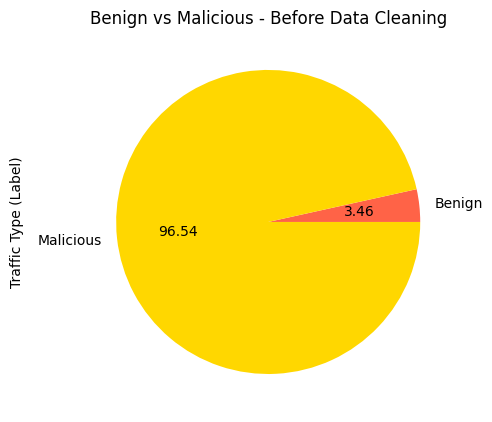

In [9]:
fig, ax2 = plt.subplots(ncols=1, figsize=(5, 5))
df_test.groupby('Label').size().plot(kind='pie', autopct='%.2f', colors=['tomato', 'gold'], textprops={'fontsize': 10})
ax2.set_ylabel('Traffic Type (Label)\n\n\n', size=10)
plt.tight_layout()
plt.title('Benign vs Malicious - Before Data Cleaning')
plt.savefig('images/pie_benign_malicious_before_cleaning_data.png')
plt.show()


In [10]:
sns.reset_orig() 
plt.close()
plt.clf()

In [11]:
print('Shape before treating duplicates: ' + str(df.shape))
print('Duplicates : ' + str(df.duplicated().sum()))


Shape before treating duplicates: (1215890, 52)
Duplicates : 1


#### will address duplicates after addressing features with more than 80% missing data.

#### The result (from removing rows with null and keeping the fetaure columns) above shows that the data becomes severly imbalanced because of ~80% loss in data. Therefore the features with missing data above 77% will be dropped.

In [12]:
df_org = df.copy(deep=True)

In [13]:
# Address Missing Data 
# Data without features that have 77% or greater missing values

df = pd.DataFrame(df_org.drop(['Unnamed: 0','SrcWin', 'DstWin', 'sVid', 'dVid', 'DstTCPBase', 'dTos', 'dDSb', 'dTtl', 'dHops', 'SrcGap', 'DstGap', 'SrcTCPBase'], axis=1))
df.dropna(inplace=True)
col_list = df.select_dtypes(include=['object', 'category']).columns.tolist()
print('_________________________________________\n')
for col in col_list:
    print('Feature: ' + str(col))
    category = df[col].value_counts().div(df.shape[0]).mul(100).round(2)
    category_df = category.reset_index()
    category_df.columns = ['category', 'freq in %']
    print(category_df)
    print('_________________________________________\n')

_________________________________________

Feature: Proto
    category  freq in %
0        udp      74.28
1        tcp      22.92
2       icmp       2.44
3       sctp       0.36
4  ipv6-icmp       0.00
_________________________________________

Feature: sDSb
   category  freq in %
0       cs0      99.47
1        ef       0.29
2      af11       0.06
3       cs6       0.05
4       cs7       0.04
5      af41       0.04
6        52       0.01
7      af12       0.01
8       cs4       0.01
9         4       0.01
10       39       0.00
11       54       0.00
_________________________________________

Feature: Cause
   category  freq in %
0    Status      59.92
1     Start      40.02
2  Shutdown       0.06
_________________________________________

Feature: State
   category  freq in %
0       REQ      48.46
1       INT      27.04
2       CON      10.87
3       RST       6.22
4       FIN       4.87
5       ECO       2.37
6       ACC       0.09
7       URP       0.06
8       RSP       0.01
9   

In [14]:
print(df.shape)
print('Duplicates : ' + str(df.duplicated().sum()))
# remove duplicates
df.drop_duplicates(inplace = True)
print('Shape post treating duplicates: ' + str(df.shape))

(1215676, 39)
Duplicates : 21
Shape post treating duplicates: (1215655, 39)


In [15]:
fig, ax2 = plt.subplots(ncols=1, figsize=(5, 5))
df.groupby('Label').size().plot(kind='pie', autopct='%.2f', colors=['tomato', 'gold'], textprops={'fontsize': 10})
ax2.set_ylabel('Traffic Type (Label)\n', size=10)
plt.tight_layout()
plt.title('Benign vs Malicious - After Data Cleaning')
plt.savefig('images/pie_benign_malicious_after_cleaning_data.png')
plt.show()

<Figure size 640x480 with 0 Axes>

#### Dropping features with more than 80% missing data resulted in data that is not as imbalanced (from a Label prespective).

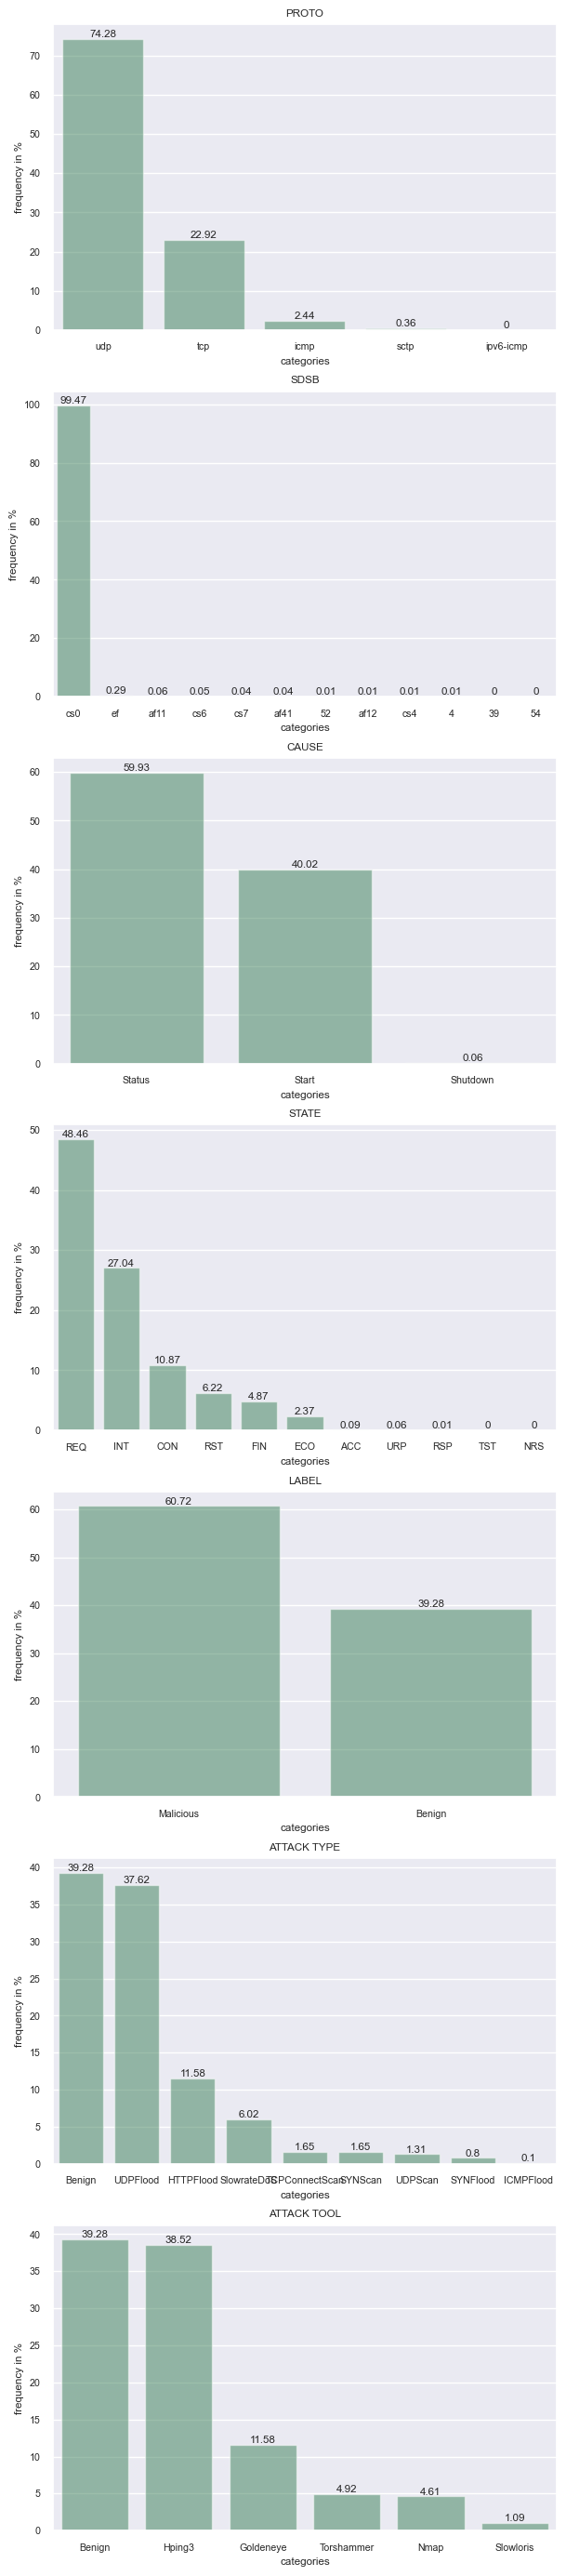

In [16]:
sns.set(style="darkgrid",font_scale=0.7)
col_list = df.select_dtypes(include=['object', 'category']).columns.tolist()
fig, axs = plt.subplots(len(col_list), 1, figsize=(7, 35))
i = 0
for col in col_list:
    category = df[col].value_counts().div(df.shape[0]).mul(100).round(2)
    category_df = category.reset_index()
    category_df.columns = ['categories', 'frequency']
    ax = sns.barplot(x = category_df.categories, y=category_df.frequency, ci=None, alpha=0.5, color='seagreen', ax=axs[i])
    ax.set_title(str(col).upper()) 
    ax.set_ylabel("frequency in %")
    for container in ax.containers:
        ax.bar_label(container)
    i = i + 1

plt.savefig('images/bar_categories.png')
plt.show()
    

#### Do we have imbalance in classes?

In [17]:
fig,ax = plt.subplots(figsize=(5, 10))
attack_counts = df.groupby(['Label', 'Attack Type']).size()
display(attack_counts.sort_values())
attack_counts.unstack('Attack Type')\
    .plot(kind='bar', stacked=True, ax=ax)
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
ax.xaxis.grid(False)
plt.title('Benign/Malicious Messages - Attack Type Breakdown')
plt.savefig('images/benign_malicious_attacktype.png')
plt.show()

Label      Attack Type   
Malicious  ICMPFlood           1155
           SYNFlood            9721
           UDPScan            15906
           SYNScan            20043
           TCPConnectScan     20052
           SlowrateDoS        73124
           HTTPFlood         140812
           UDPFlood          457340
Benign     Benign            477502
dtype: int64

#### Indeed, we do see class imbalances when it comes to Attack Type (classification of malicious attacks). The most noticeable are:

- UDPFlood
- UDPScan
- TCPConnectScan
- SYNScan
- SYNFlood
- ICMPFlood

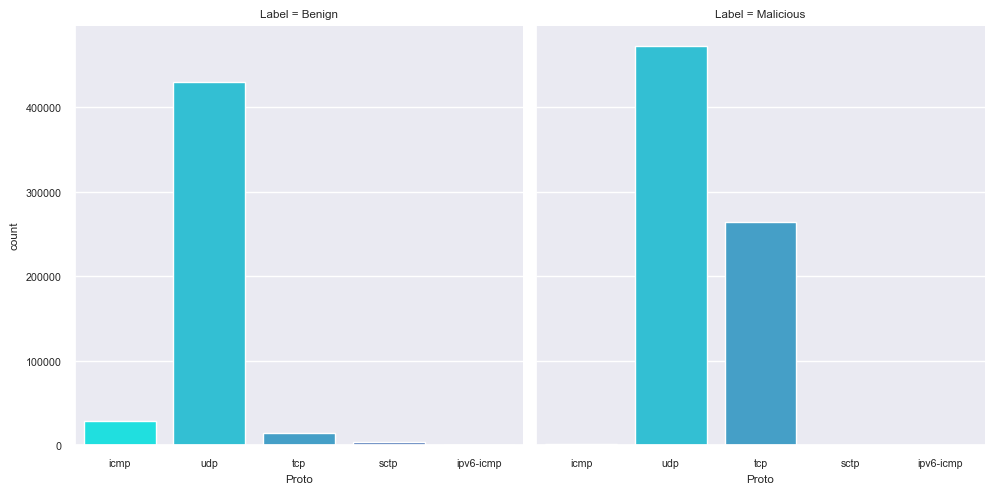

In [18]:
countplots = partial(sns.catplot, data=df, kind='count', col_wrap=3, palette=sns.color_palette('blend:#0FF,#72A'))
countplots(x='Proto', col='Label', col_wrap=2)
plt.savefig('images/proto_benign_malicious.png')
plt.show()

In [19]:
# Lets 
df_trans =df.copy(deep=True)
df_trans['Label'] = df_trans['Label'].replace({'Benign': 0, 'Malicious': 1})

In [20]:
def plot_cat_func(attr):
    df_proto = pd.merge( df_trans[df_trans['Label']==1].groupby([attr]).size().to_frame(), \
               df_trans[df_trans['Label']==0].groupby([attr]).size().to_frame(), \
                left_on=attr, right_on=attr, how='outer')

    df_tmp = pd.DataFrame(df_proto)
    df_tmp.rename(columns = {'0_x':'Malicious', '0_y':'Benign'}, inplace=True);
    df_tmp.reset_index(inplace=True)
    dfm = pd.melt(df_tmp, id_vars=attr, var_name='Traffic Type', value_name='Count')
    plt.close()
    sns.set(style="darkgrid",font_scale=0.8)
    grid = sns.catplot(x=attr, y='Count', hue='Traffic Type', data=dfm, kind='bar', height=5, aspect=2, \
                       palette=["darkred", "seagreen"])
    ax = grid.axes[0, 0]
    for container in ax.containers:
        ax.bar_label(container)

    plt.xticks(rotation=60) 
    plt.title('\nMalicious Vs Benign Distribution per ' + str(attr) + ' Category');
    plt.savefig('images/' + str(attr) + '_benign_malicious_distribution.png', bbox_inches='tight')
    plt.show()
    plt.close()
    return 

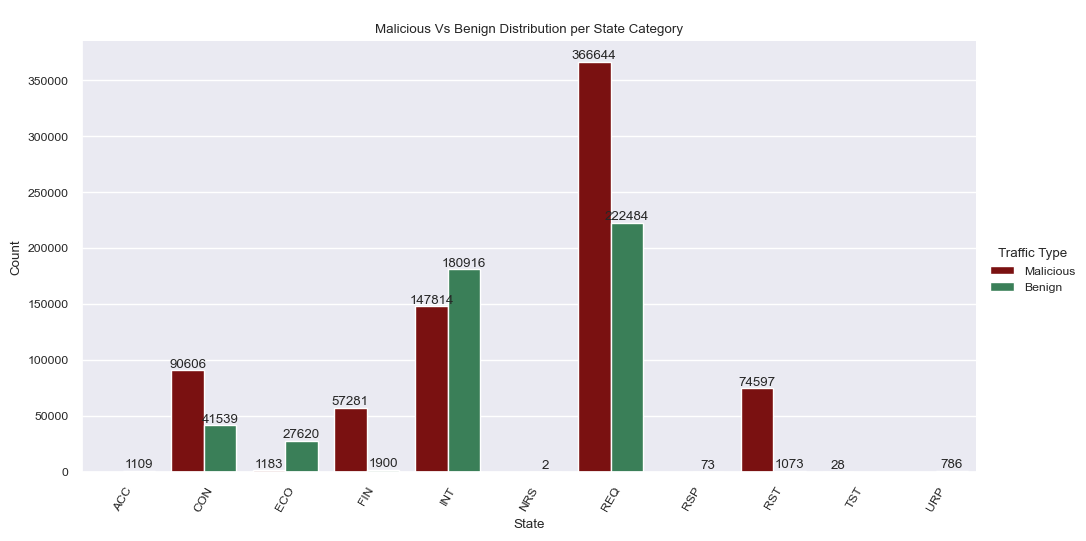

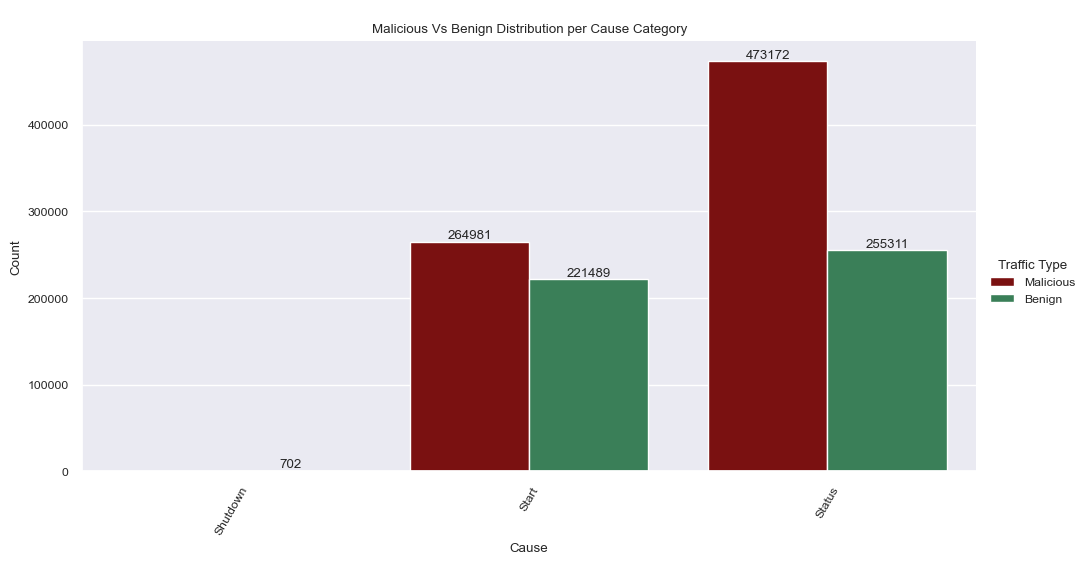

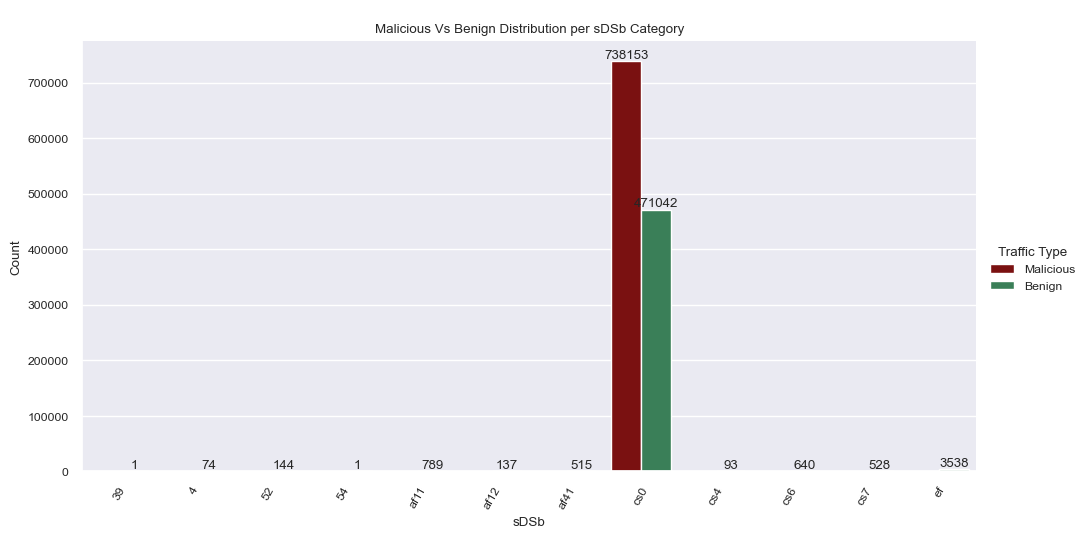

In [21]:

plot_cat_func('Proto')
plot_cat_func('State')
plot_cat_func('Cause')
plot_cat_func('sDSb')

In [22]:
# Drill down
fig, ax = plt.subplots(figsize=(10, 7))
sns.set(style="darkgrid",font_scale=0.8)
ax = sns.histplot(data=df_trans[df_trans['Label']==1], x='Attack Type', hue='Proto', palette = {'gold', 'orange', 'blue'}, ax=ax, alpha=0.5)
ax.set_title("Attack Type Distribution")
ax.set_xlabel("Attack Type")
ax.set_ylabel("Melicious Traffic Count")
for c in ax.containers:
    labels = [f'{h:0}' if (h := v.get_height()) != 0 else '' for v in c ]
    ax.bar_label(c, labels=labels, fontsize=8, padding=3)
plt.savefig('images/attack_type_dist.png', bbox_inches='tight')

#### Drill down on Melicious messages at an Attack Level

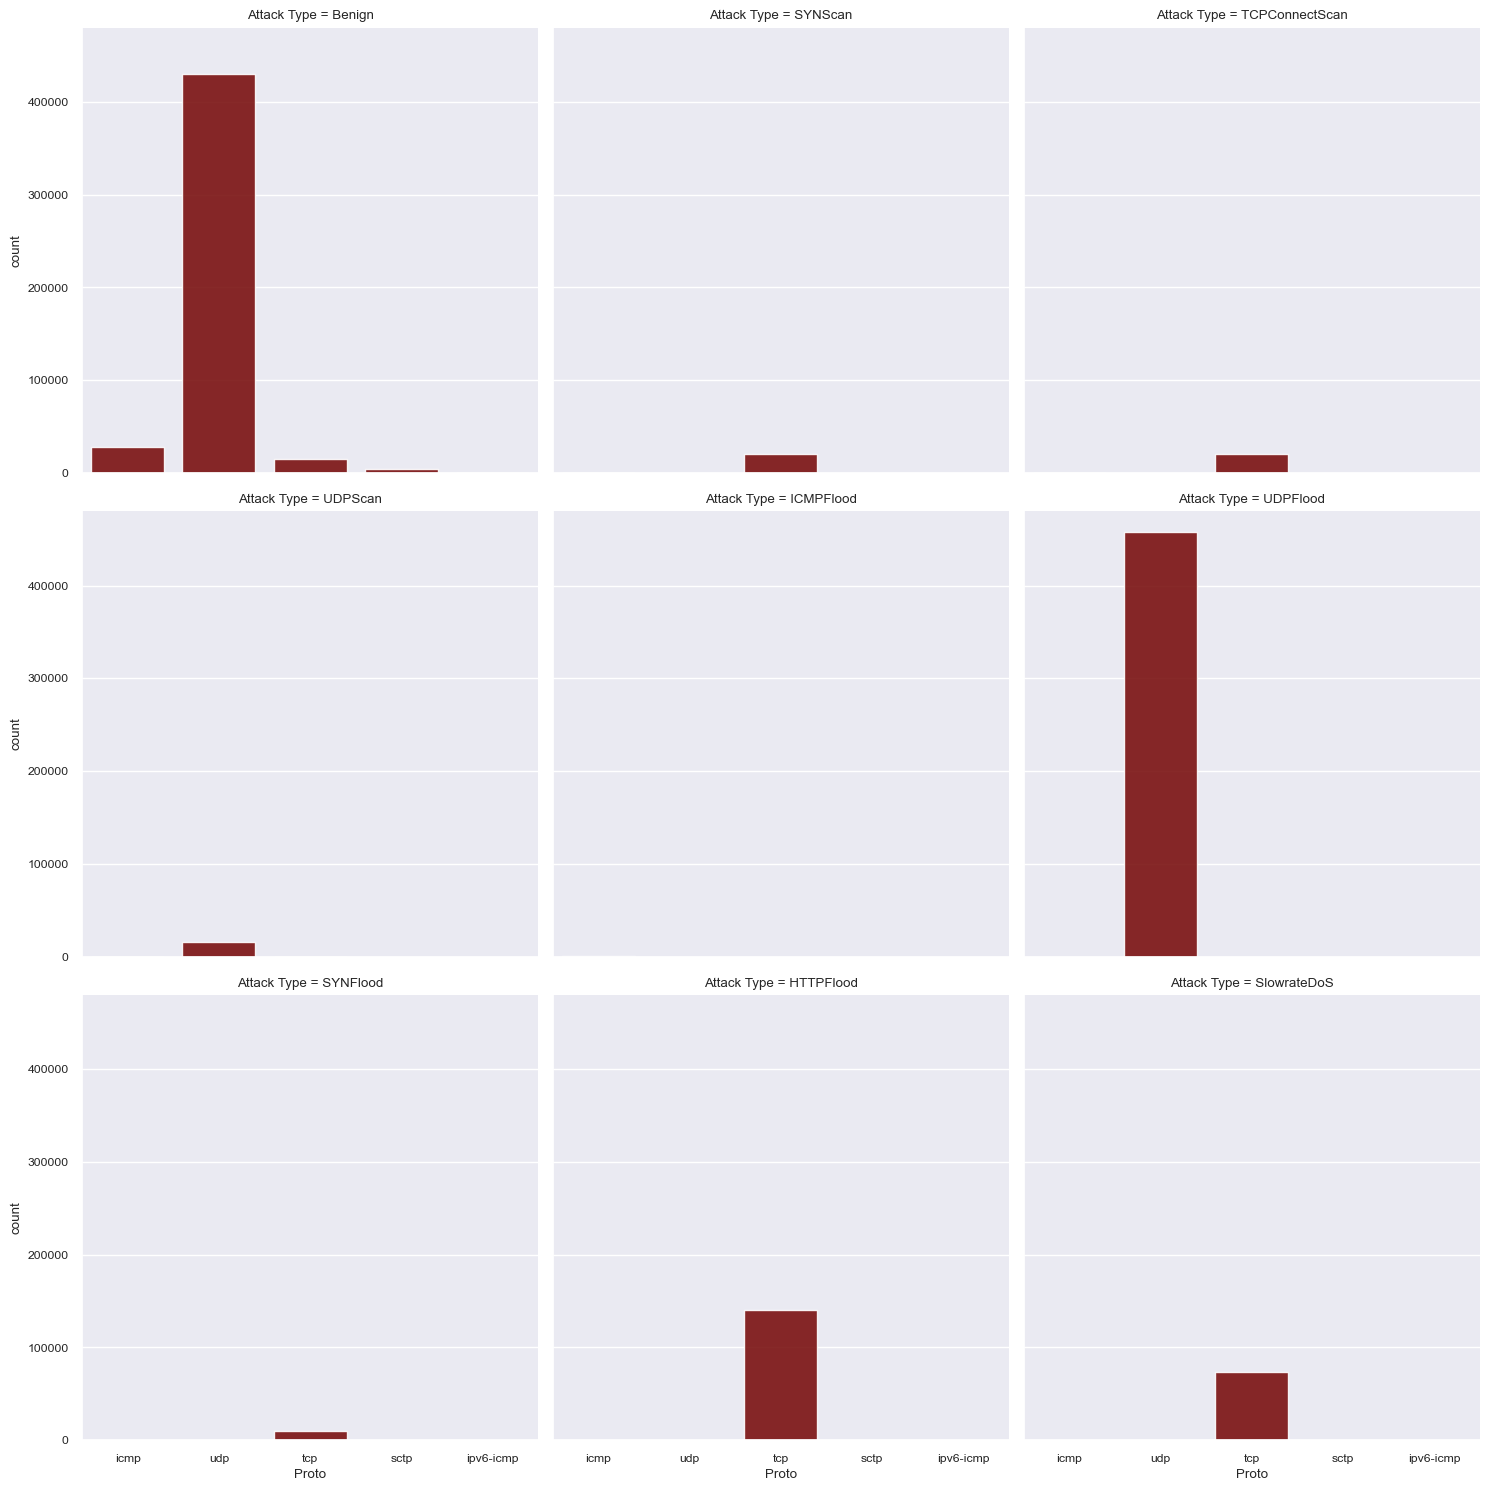

In [23]:
countplots = partial(sns.catplot, data=df, kind='count', col_wrap=3, color='darkred', alpha=0.9)
countplots(x='Proto', col='Attack Type', col_wrap=3)
plt.savefig('images/proto_attacktypes.png',bbox_inches='tight')
plt.show()

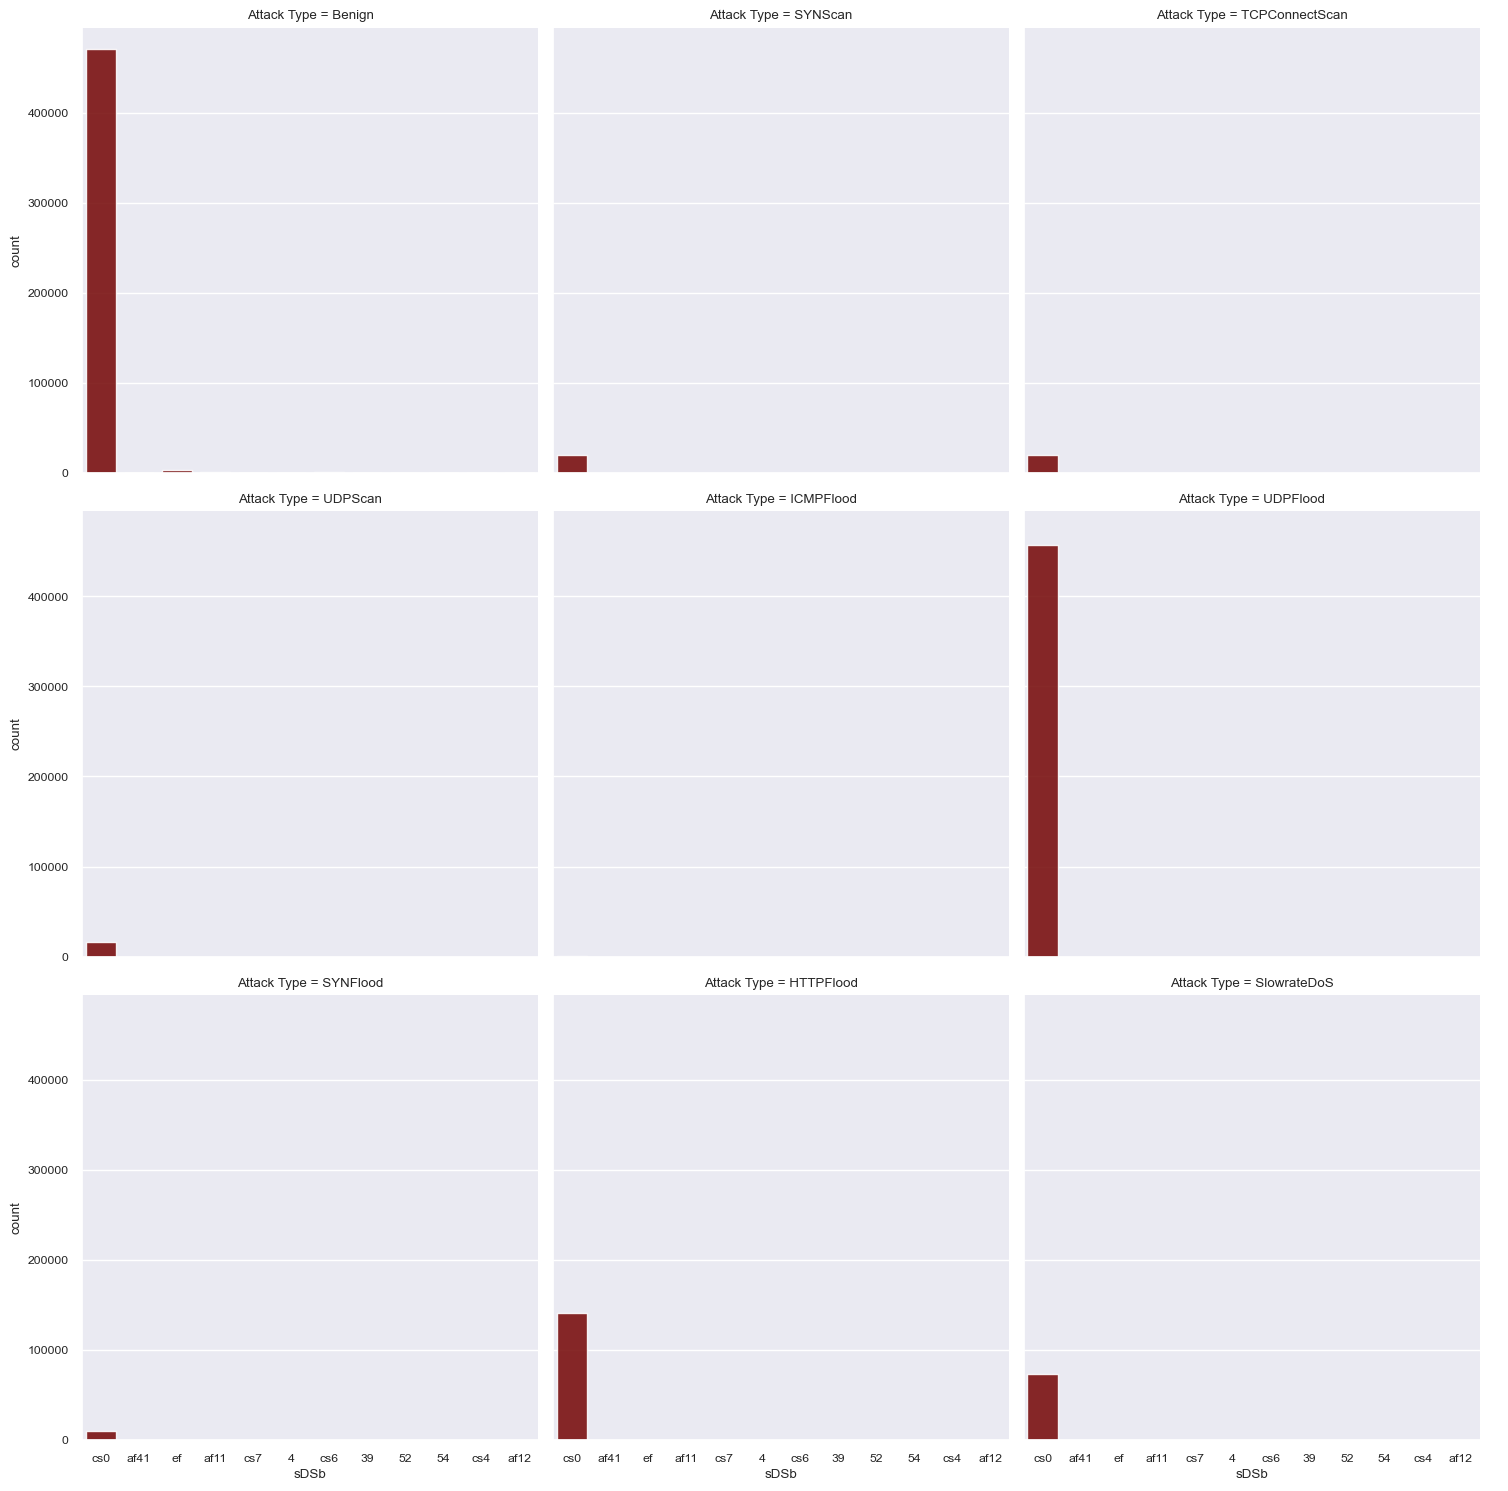

In [24]:
countplots = partial(sns.catplot, data=df, kind='count', col_wrap=3, color='darkred', alpha=0.9)
countplots(x='sDSb', col='Attack Type', col_wrap=3)
plt.savefig('images/sdsb_attacktypes.png',bbox_inches='tight')
plt.show()

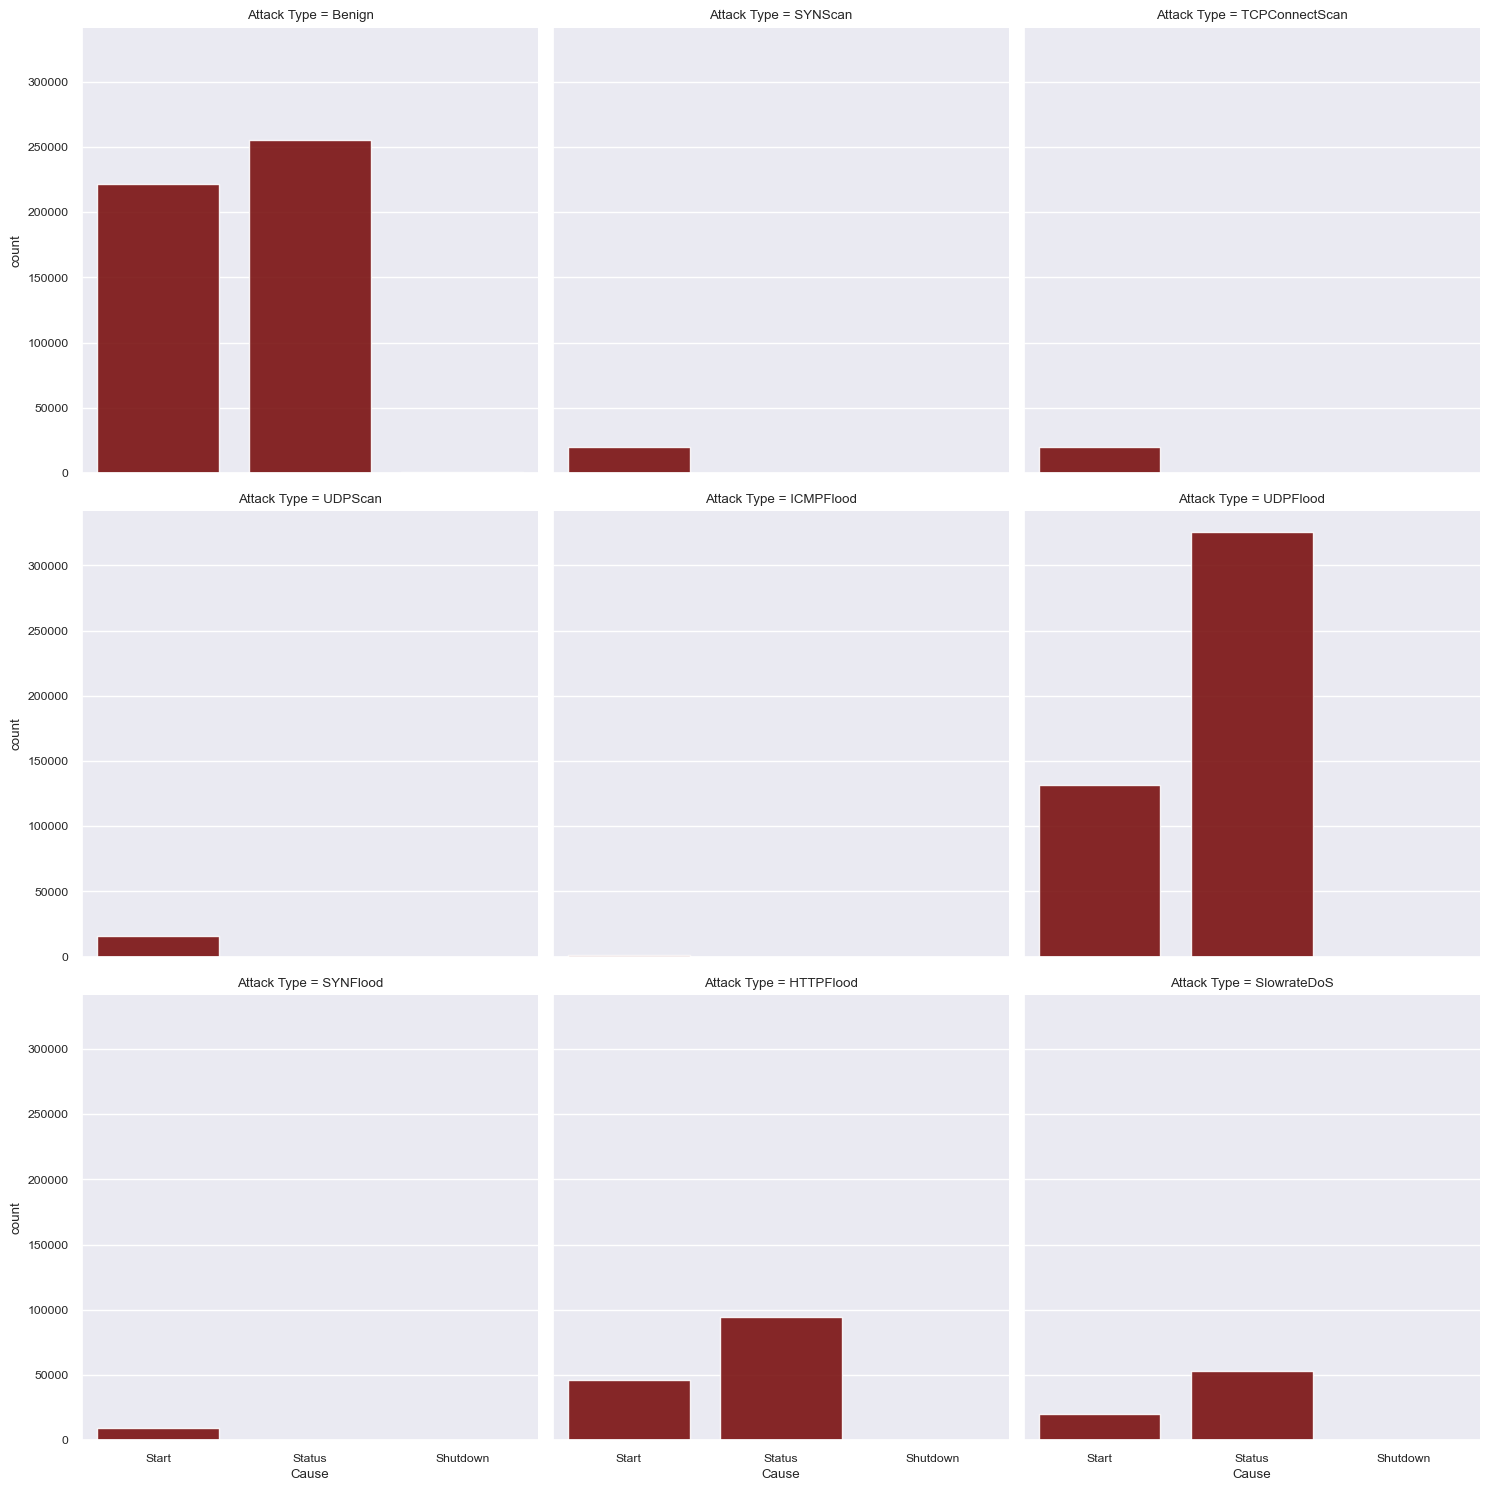

In [25]:
countplots = partial(sns.catplot, data=df, kind='count', col_wrap=3, color='darkred', alpha=0.9)
countplots(x='Cause', col='Attack Type', col_wrap=3)
plt.savefig('images/cause_attacktypes.png', bbox_inches='tight')
plt.show()

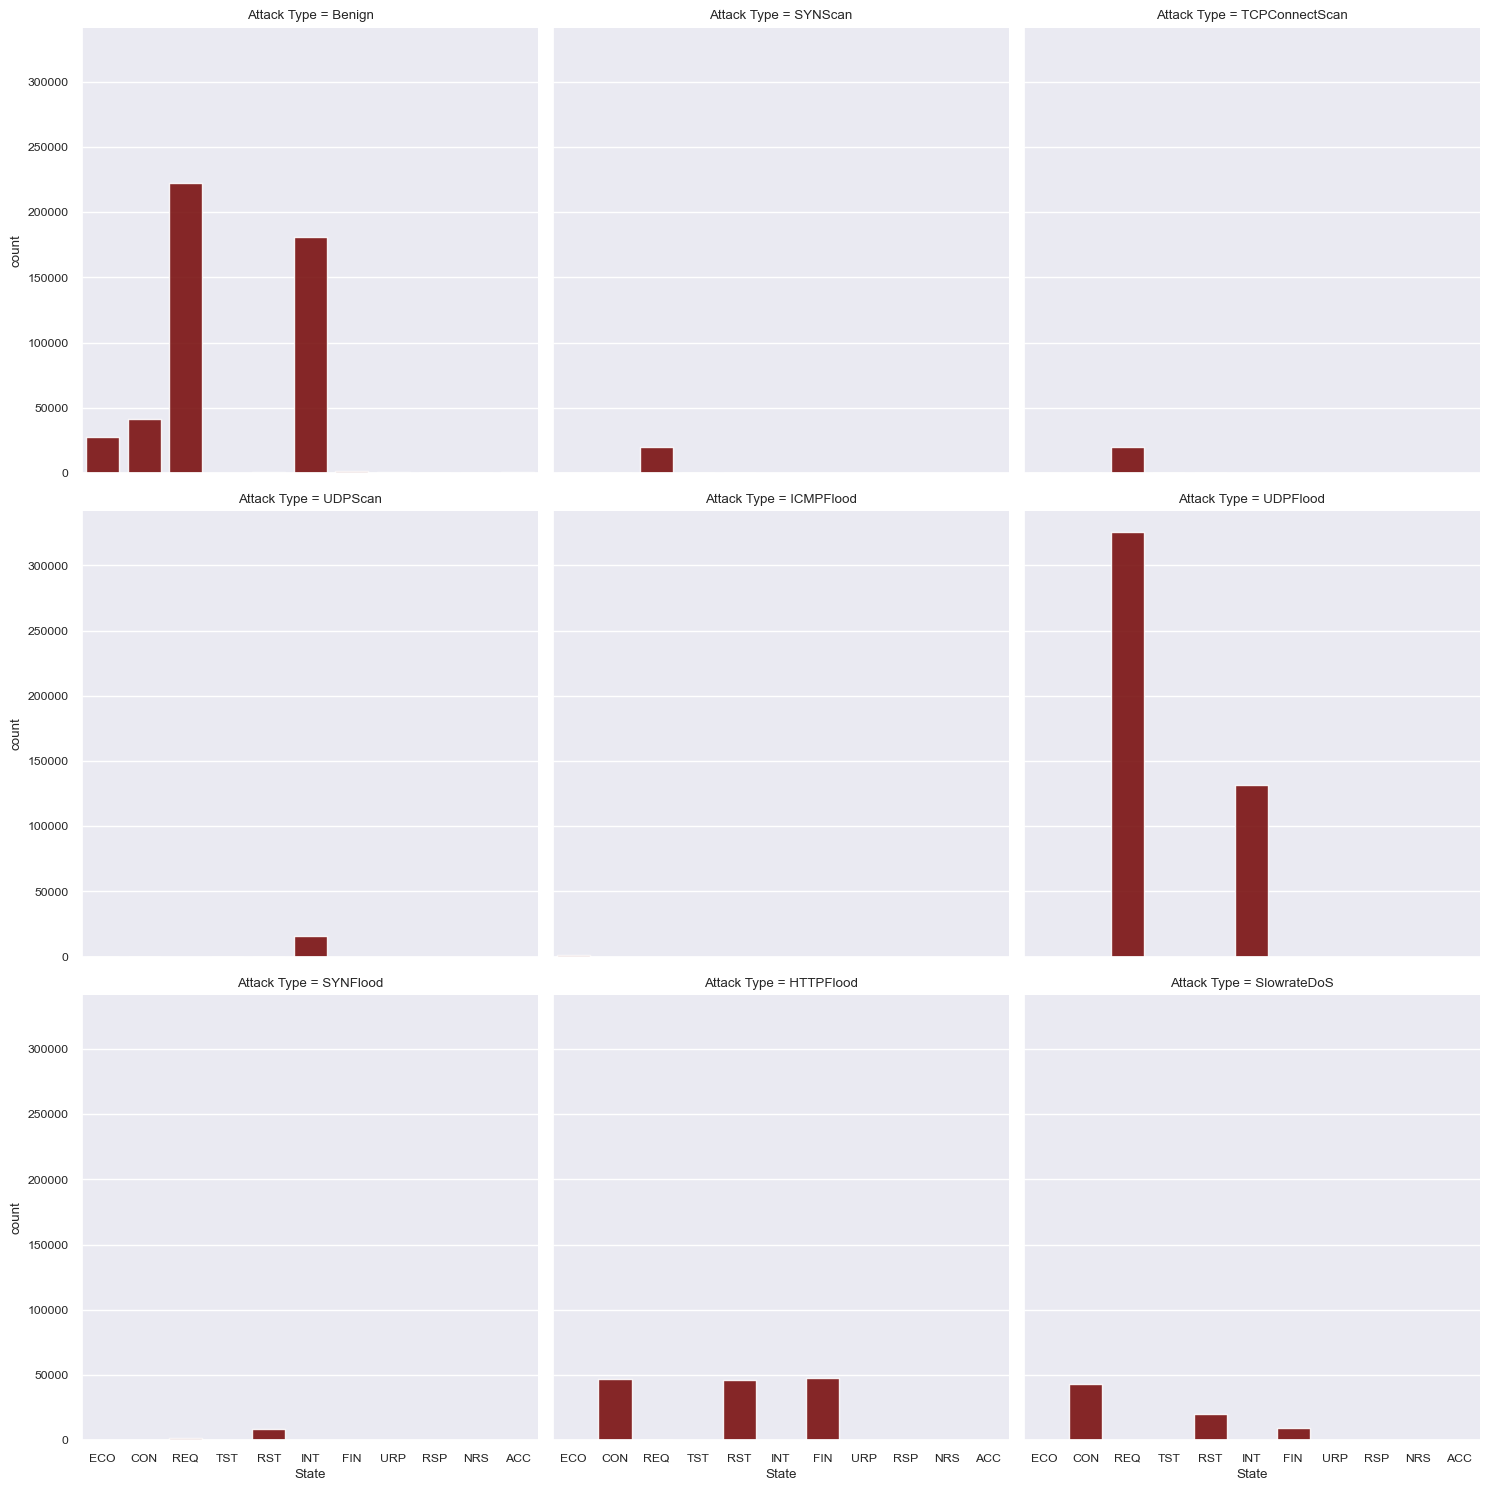

In [26]:
countplots = partial(sns.catplot, data=df, kind='count', col_wrap=3, color='darkred', alpha=0.9)
countplots(x='State', col='Attack Type', col_wrap=3)
plt.savefig('images/state_attacktypes.png', bbox_inches='tight')
plt.show()

### Lets examine the numerical features against Labels

### Understanding the Task & how to proceed
Per the problem statement, we will have two levels of preditions - Label and Attack Type. The classification approach will be as follows:
- Lable will be binary classification
- Attack Type will be multi-class classification using one-versus-one strategy.
- a) Because 'Attack Type' multiclass is what we will predict, ordinal encoder method will be used.
- b) Rest of categorical features will be encoded using OneHot encoding
- c) Multi-collinearity will be addressed by dropping features with correlation above 70%
- d) The 'Attack Tool' features will be dropped since it is captured in the 'Attack Type'. Additionally, 'Attack Tool' is not relevent to our problem statement.
    

### Starting with examining the numerical features and identify the ones that can be dropped

In [27]:
# The 'Attack Tool' features will be dropped since the the former captured in the 'Attack Type' and 'Attack Tool' is not relevent to our problem statement.

#Ordinal encoder
dict = {'Benign': 0, 'UDPFlood': 1, 'HTTPFlood': 2, 'SlowrateDoS': 3, 'TCPConnectScan': 4, 'SYNScan': 5, 'UDPScan': 6, 'SYNFlood': 7, 'ICMPFlood': 8}

# Continue uding df_trans since 'Label' is already transformed to numerical
df_trans.replace({'Attack Type':dict},inplace=True);

df_trans.drop(['Attack Tool'], axis=1, inplace=True)


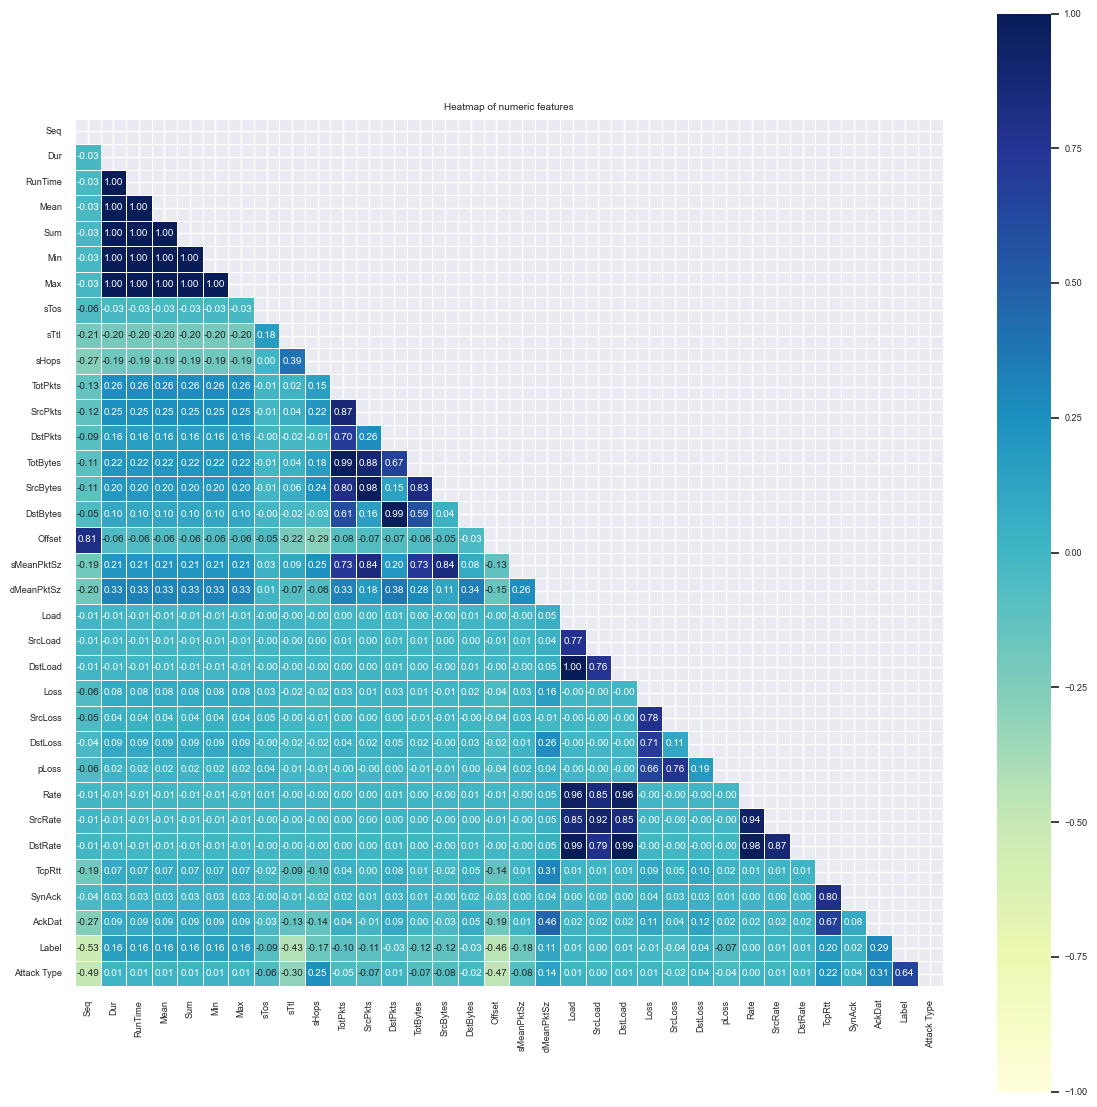

In [28]:
plt.figure(figsize = (14,14))
plt.rcParams.update({'font.size': 6})
numeric_corr = df_trans.corr(numeric_only=True)
sns.set(style="darkgrid",font_scale=0.6)
mask = np.triu(np.ones_like(numeric_corr, dtype=bool))
sns.heatmap(numeric_corr, cmap="YlGnBu", vmin = -1, vmax = 1, center = 0, annot=True, fmt=".2f", square=True, linewidths=.5, mask = mask)
plt.title("Heatmap of numeric features")
plt.savefig('images/heatmap_identify_relevent_features.png', bbox_inches='tight')
plt.show()

In [29]:
sns.reset_orig() 
plt.close()
plt.clf()

In [30]:
numerical_columns = df_trans.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df_trans[numerical_columns].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than a user set value 0.80
TO_DROP = [column for column in upper.columns if any(upper[column] > 0.80)]
print("Features to Drop:",TO_DROP)

df_trans.drop(TO_DROP, axis=1, inplace=True)


Features to Drop: ['RunTime', 'Mean', 'Sum', 'Min', 'Max', 'SrcPkts', 'TotBytes', 'SrcBytes', 'DstBytes', 'Offset', 'sMeanPktSz', 'DstLoad', 'Rate', 'SrcRate', 'DstRate']


In [31]:
# Lets examine the numerical features against 'Label' & 'Attack Type'
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
df_numb = df[numerical_columns].copy(deep=True)
df_numb.drop(TO_DROP, axis=1, inplace=True)

In [32]:
df_numb['Label'] = df['Label']
sns.reset_orig() 
plt.close()
plt.clf()
sns.set_style('whitegrid')
sns_plot = sns.pairplot(df_numb.sample(300000), hue='Label', diag_kind='kde', corner=True, palette = {'darkred','seagreen'})
sns_plot.savefig("images/pairplot_numeric_features_label.png")
plt.clf()

In [33]:
sns.reset_orig() 
plt.close()
plt.clf()

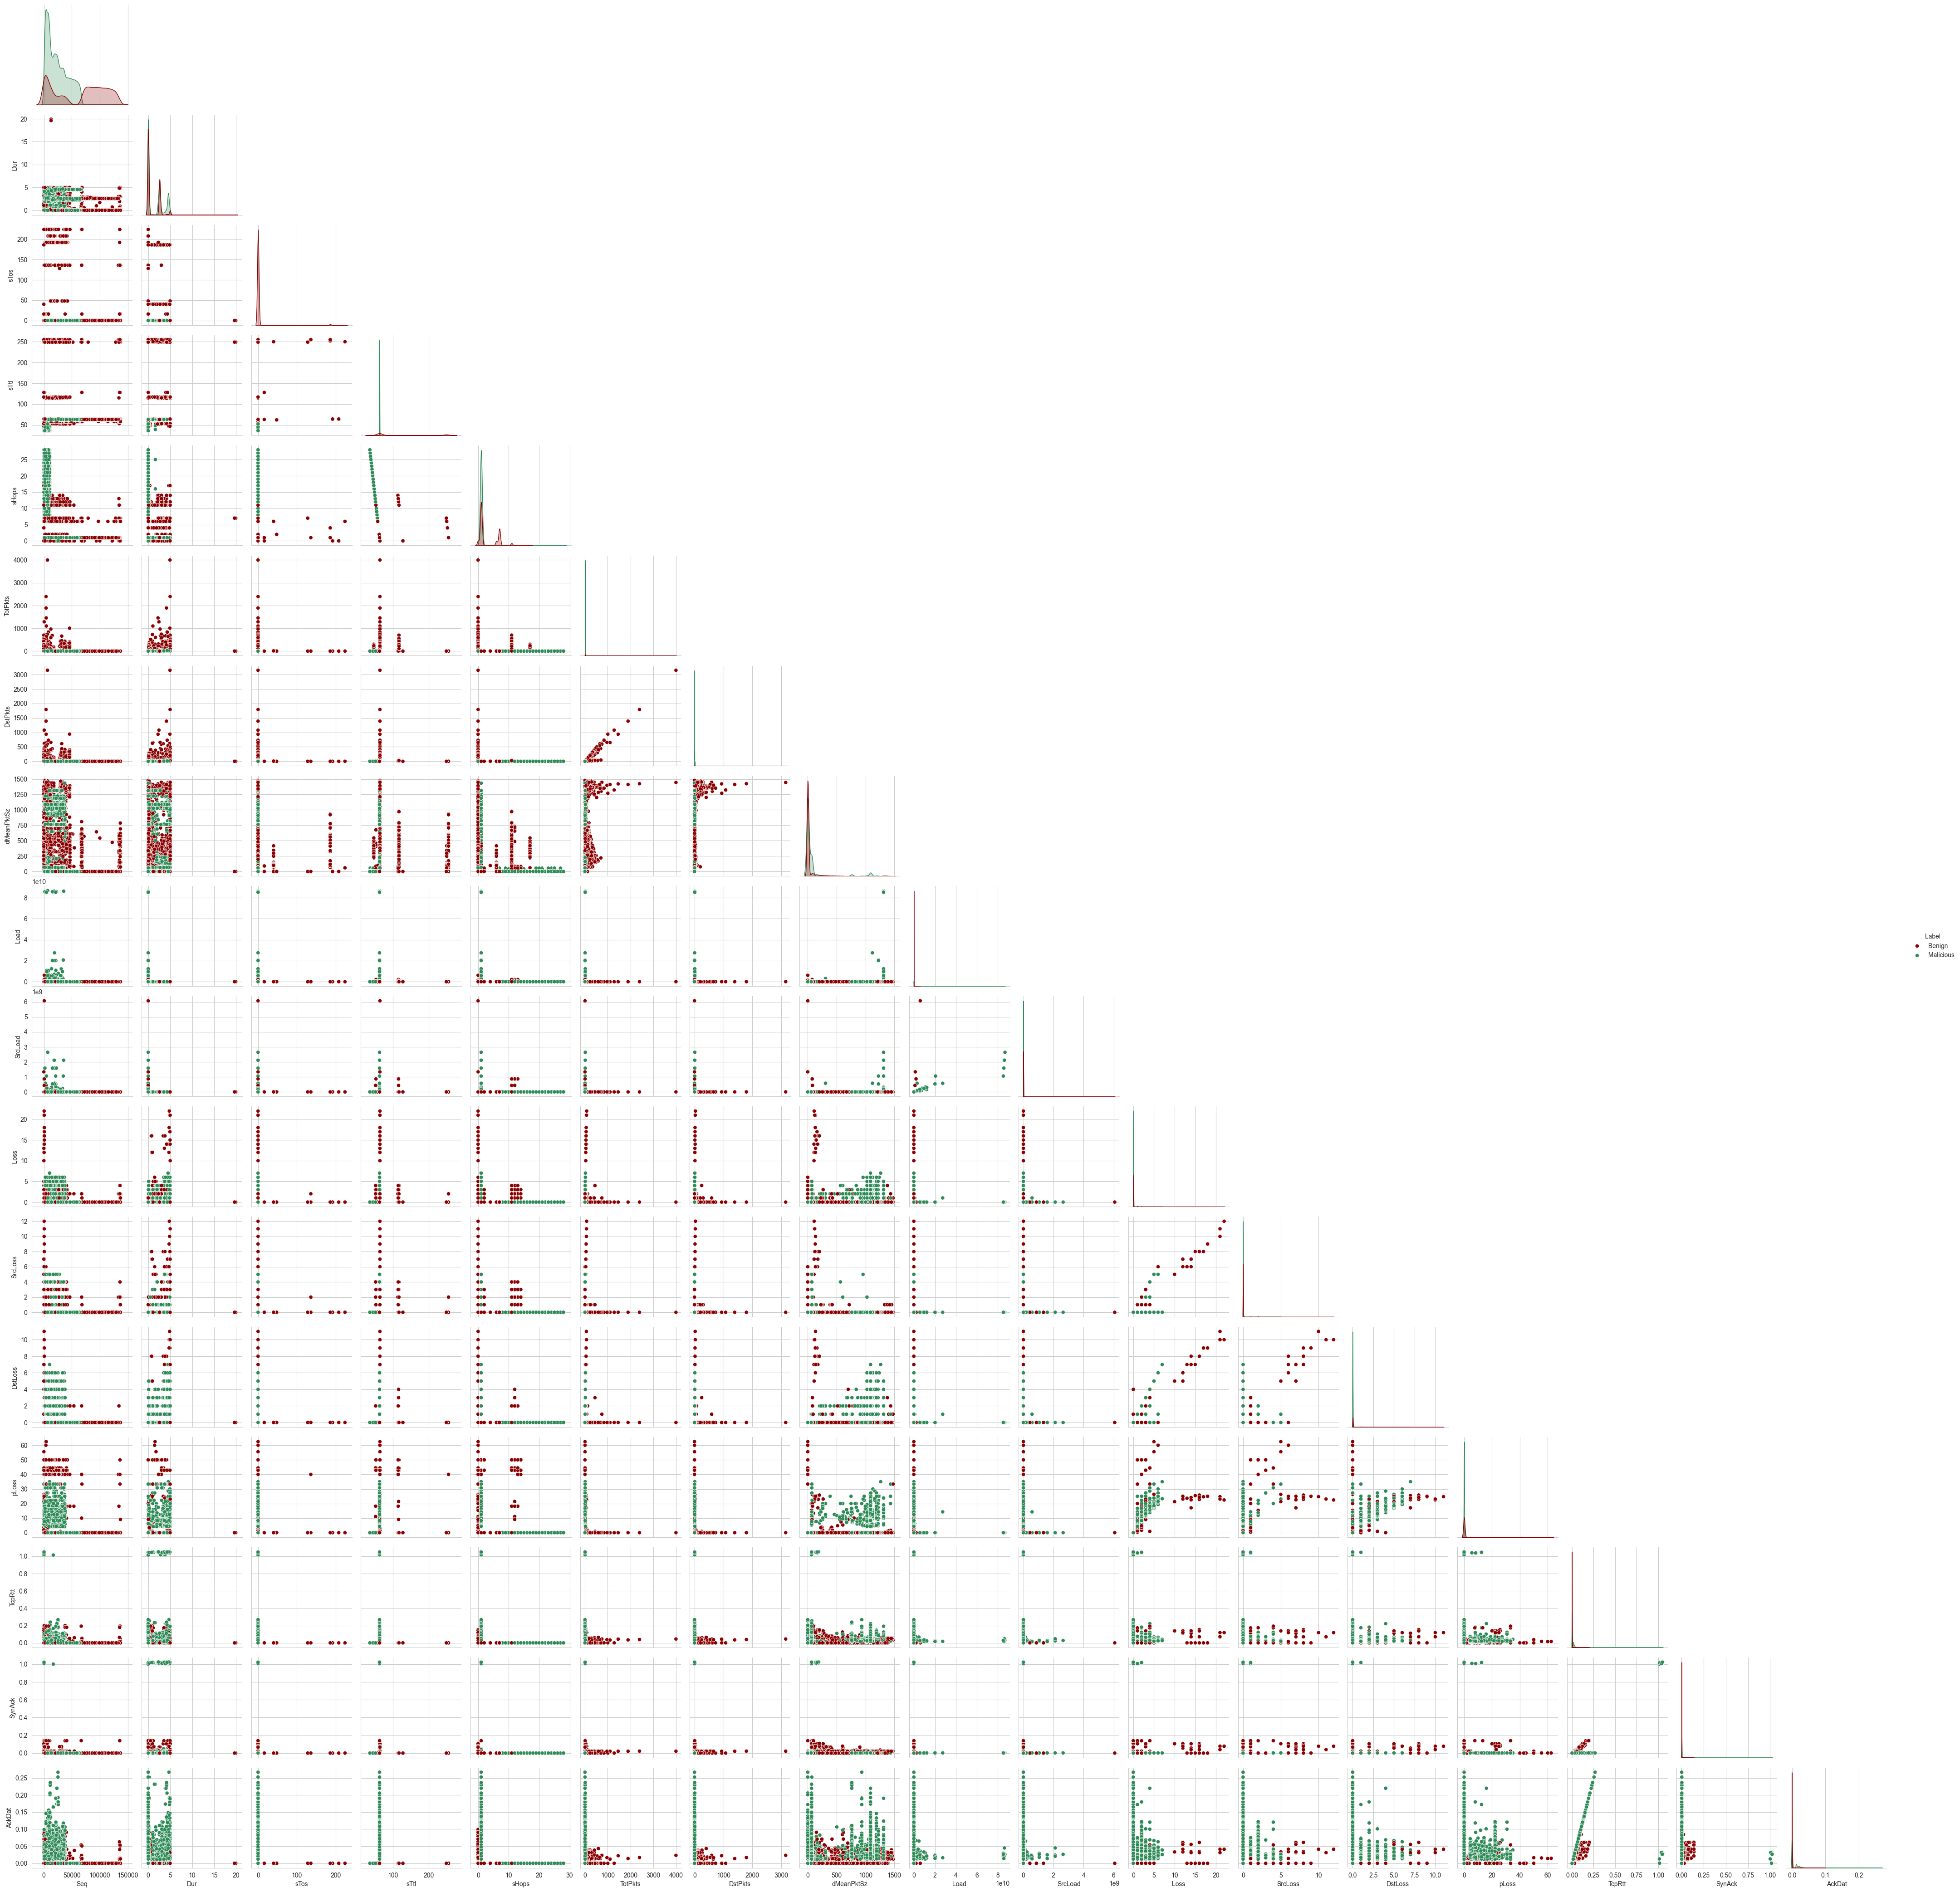

In [34]:
from IPython.display import Image
Image(filename='images/pairplot_numeric_features_label.png') 

In [35]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
df_tmp = df[numerical_columns].copy(deep=True)
df_tmp['Attack Type'] = df['Attack Type']
df_numb = df_tmp[(df_tmp['Attack Type'] != 'Benign')].copy(deep=True)
df_numb.drop(TO_DROP, axis=1, inplace=True)

In [36]:
#df_numb.drop('Label', axis=1, inplace=True)
sns.reset_orig() 
plt.close()
plt.clf()
sns.set_style('whitegrid')
sns_plot = sns.pairplot(df_numb.sample(300000), hue='Attack Type', diag_kind='kde', corner=True, palette='CMRmap')
sns_plot.savefig("images/pairplot_numeric_features_attack_type.png")
plt.clf()

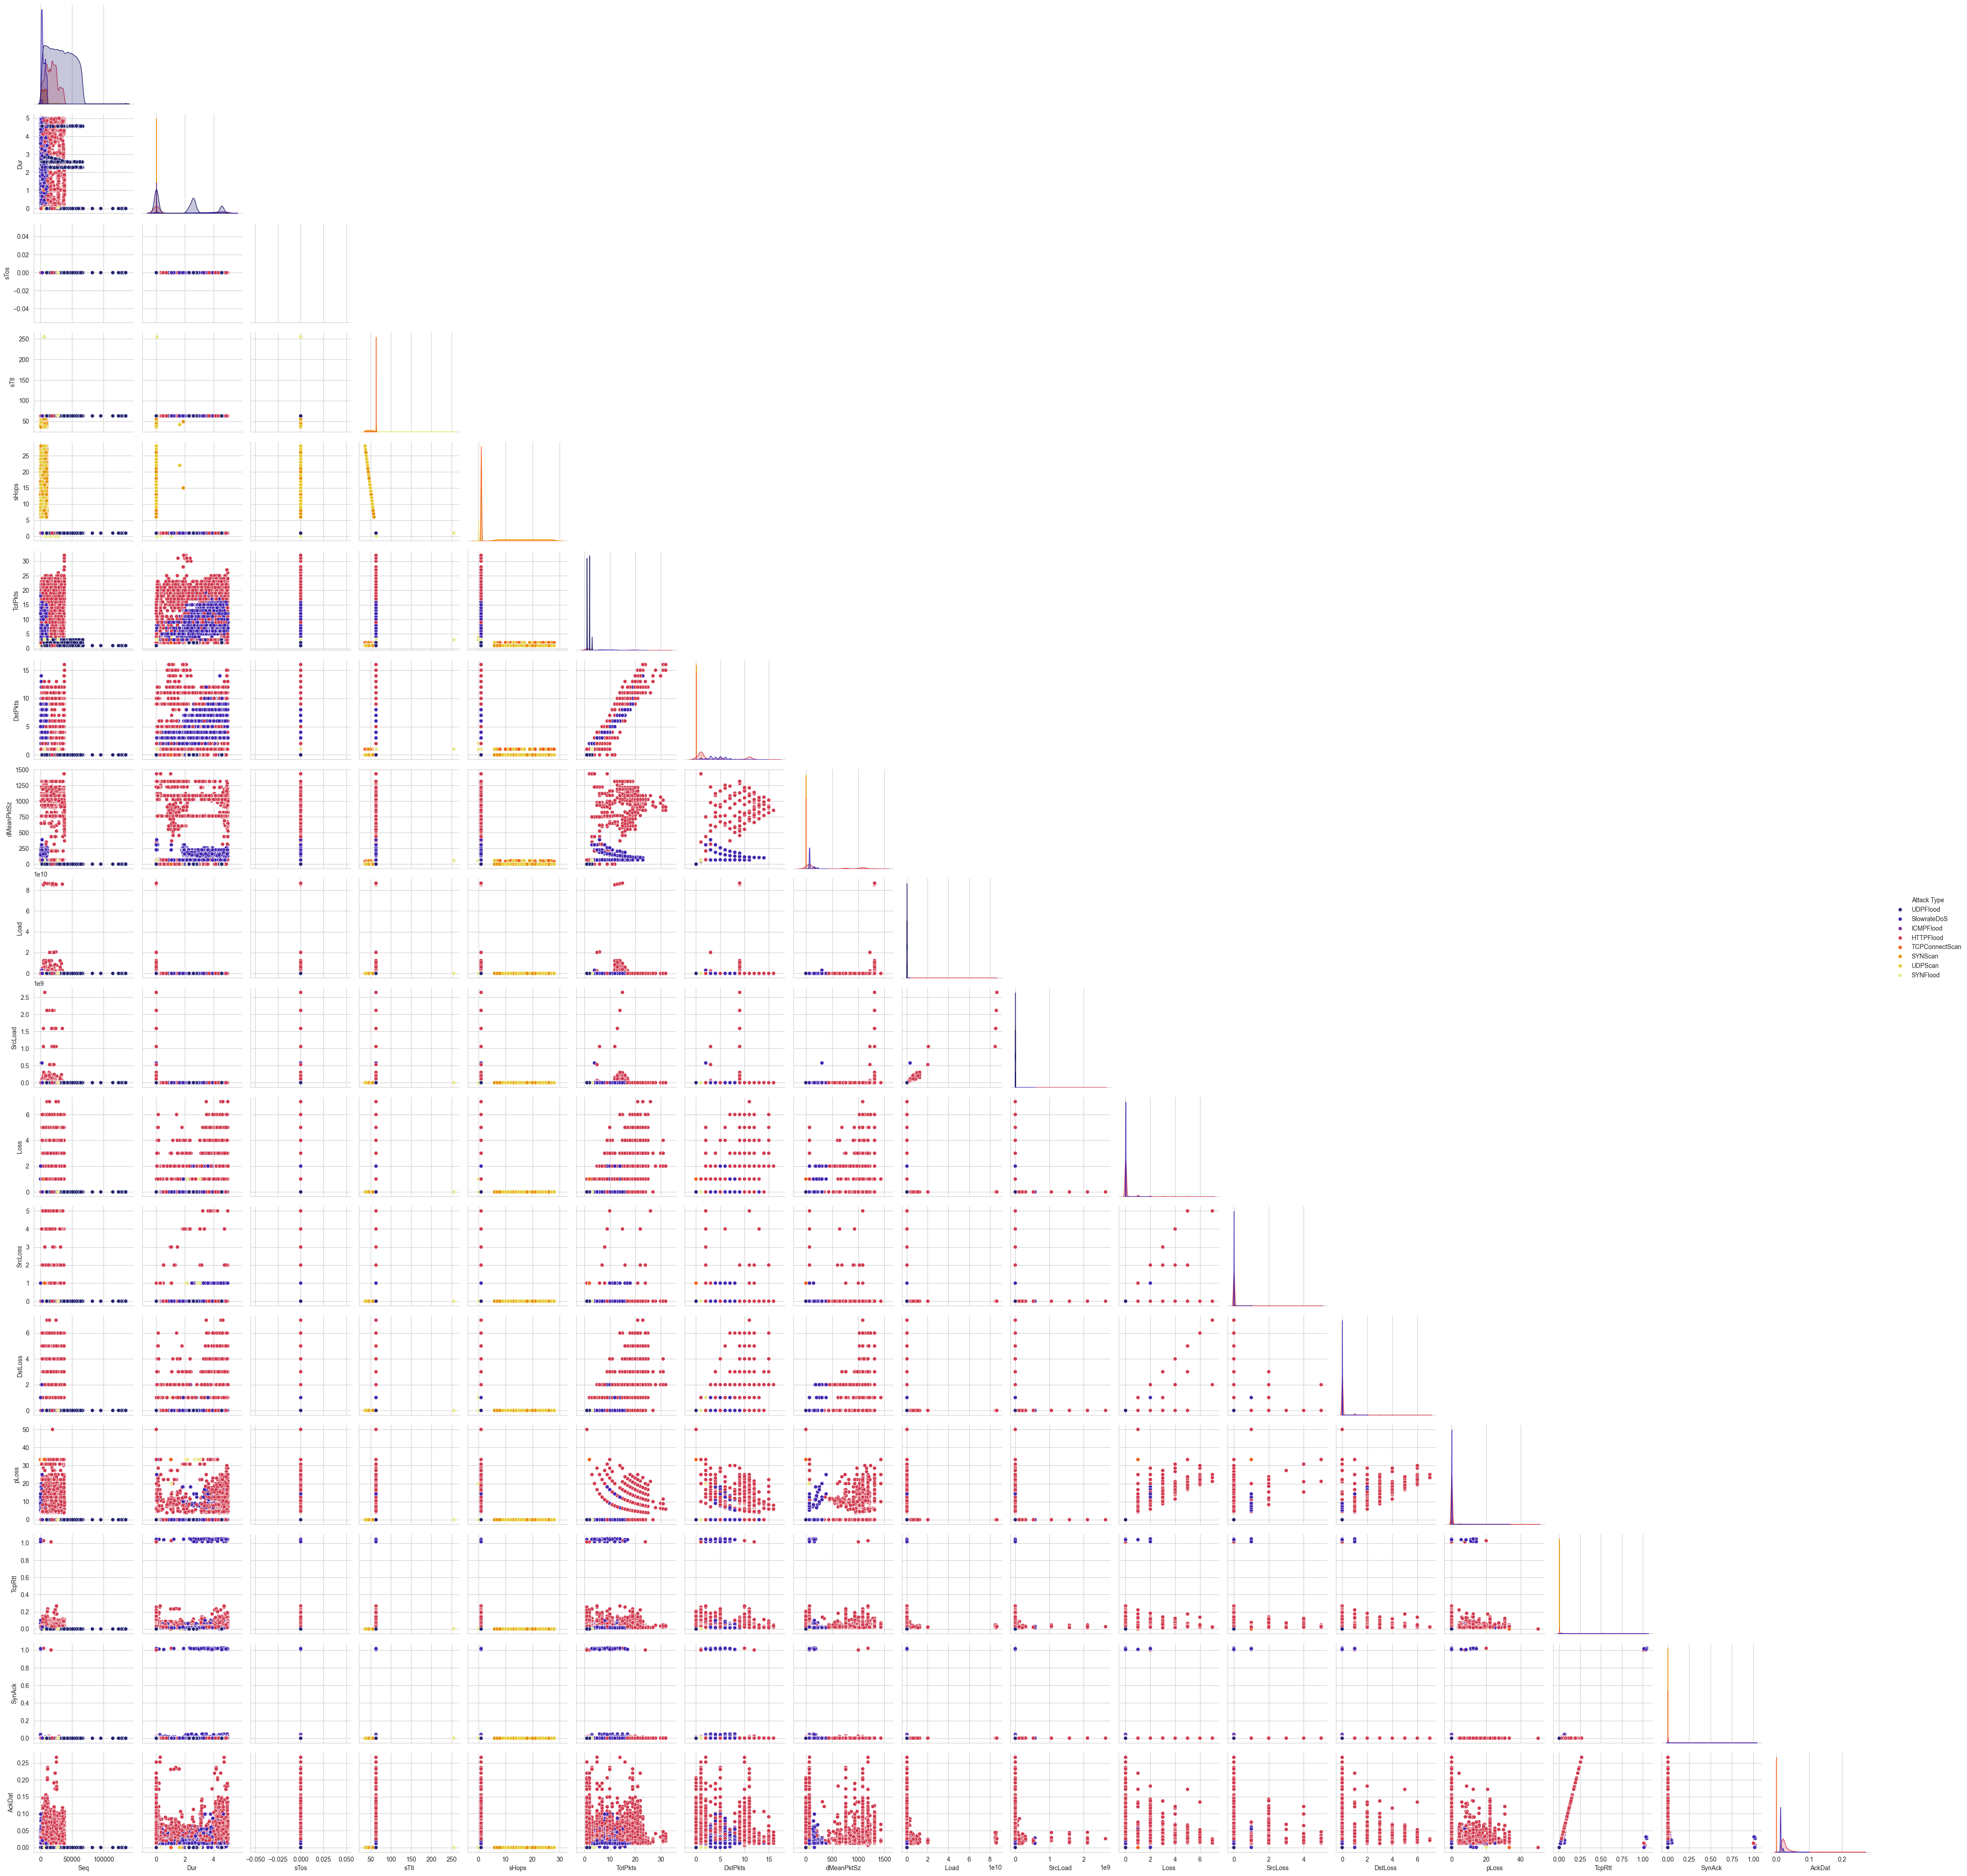

In [37]:
Image(filename='images/pairplot_numeric_features_attack_type.png') 

In [38]:
sns.reset_orig() 
plt.close()
plt.clf()

# Clean data
display(df_trans.info())
display(df_trans.decribe)

### Engineering Features

Per the business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data and repare the features and target column for modeling with appropriate encoding and transformations.

In [39]:
#OneHotEncoding
categorical_columns = df_trans.select_dtypes(include=['object', 'category']).columns

encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(df_trans[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns)).reset_index()
tmp_data = df_trans.drop(categorical_columns, axis=1).reset_index()
clean_df = pd.concat([tmp_data, one_hot_df], axis=1)
clean_df.drop('index', axis=1, inplace=True)

<Figure size 640x480 with 0 Axes>

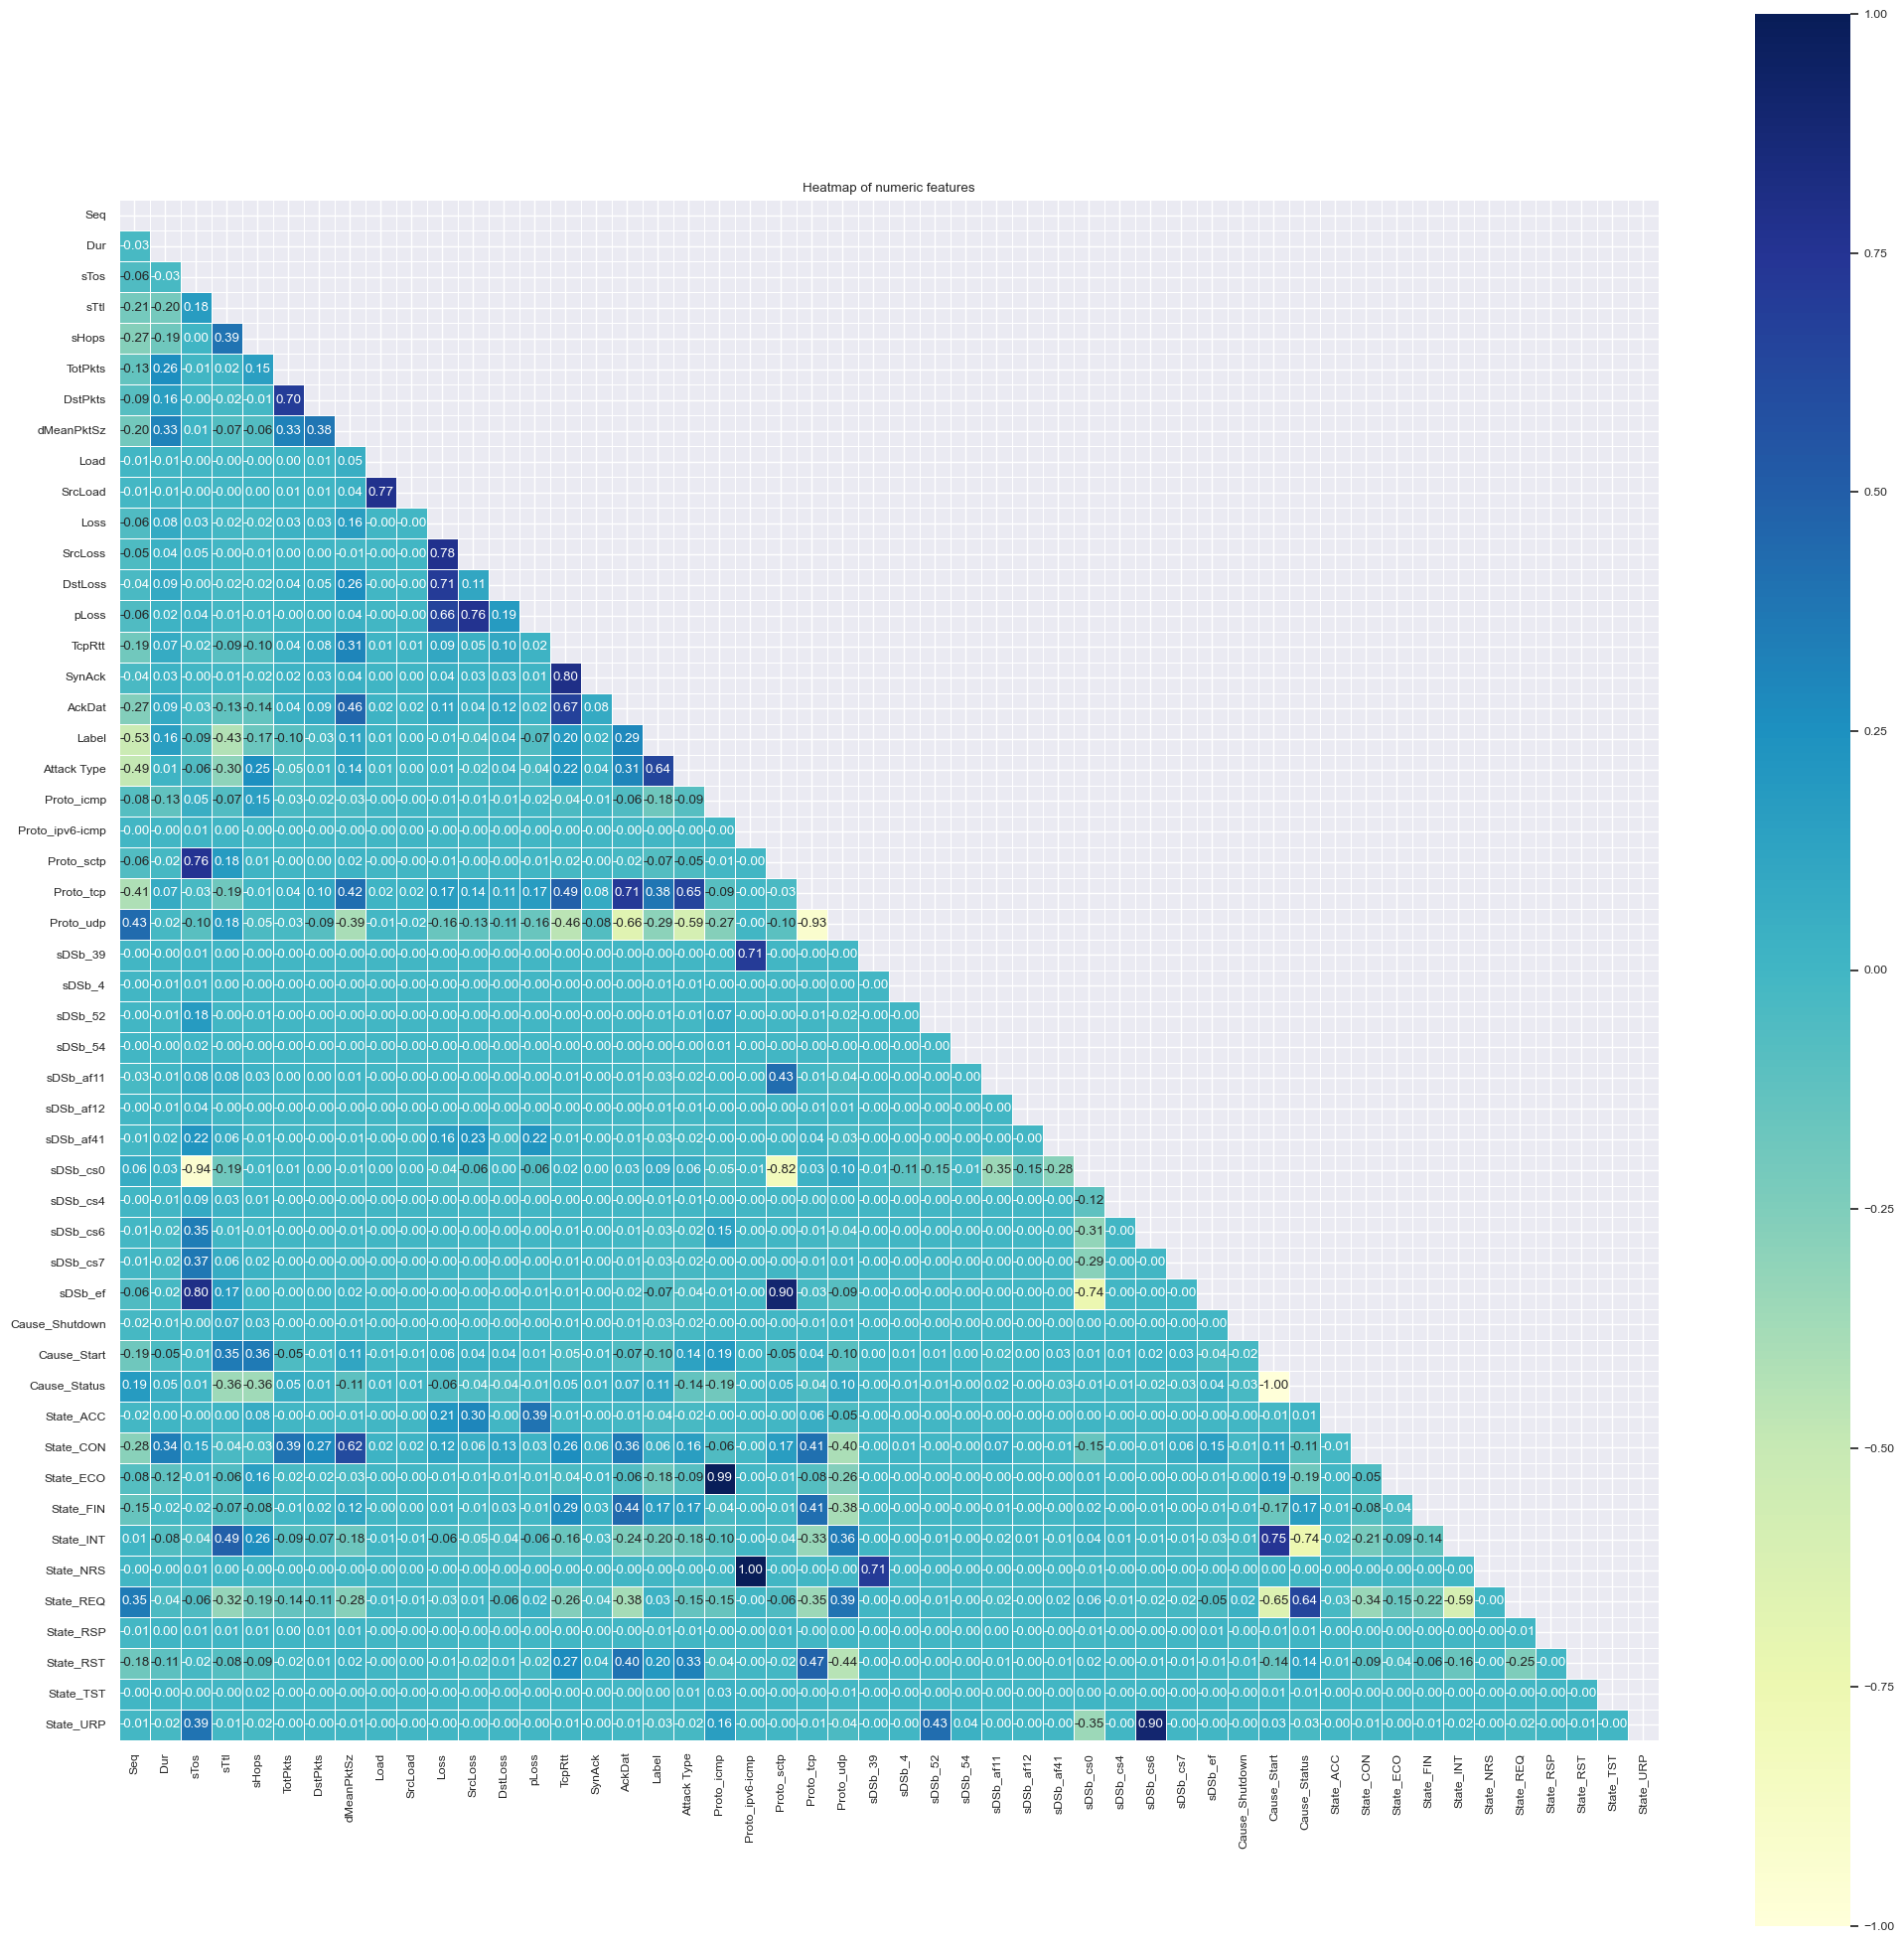

In [40]:
plt.figure(figsize = (25,25))
plt.rcParams.update({'font.size': 8})
numeric_corr = clean_df.corr(numeric_only=True)
sns.set(style="darkgrid",font_scale=0.8)
mask = np.triu(np.ones_like(numeric_corr, dtype=bool))
sns.heatmap(numeric_corr, cmap="YlGnBu", vmin = -1, vmax = 1, center = 0, annot=True, fmt=".2f", square=True, linewidths=.5, mask = mask)
plt.title("Heatmap of numeric features")
plt.savefig('images/heatmap_numeric_features_encoded.png', bbox_inches='tight')
plt.show()
plt.close()
plt.clf()

In [41]:
sns.reset_orig() 
plt.close()
plt.clf()

In [42]:
numerical_columns = clean_df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = clean_df[numerical_columns].corr().abs()

   
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))


# Find index of feature columns with correlation greater than a user set value 0.80
TO_DROP = [column for column in upper.columns if any(upper[column] > 0.80)]
print("Features to Drop:",TO_DROP)

#clean_df.drop(TO_DROP, axis=1, inplace=True)

Features to Drop: ['Proto_udp', 'sDSb_cs0', 'sDSb_ef', 'Cause_Status', 'State_ECO', 'State_NRS', 'State_URP']


In [43]:
Will_Drop = TO_DROP
clean_df.drop(Will_Drop, axis=1, inplace=True)

<Figure size 640x480 with 0 Axes>

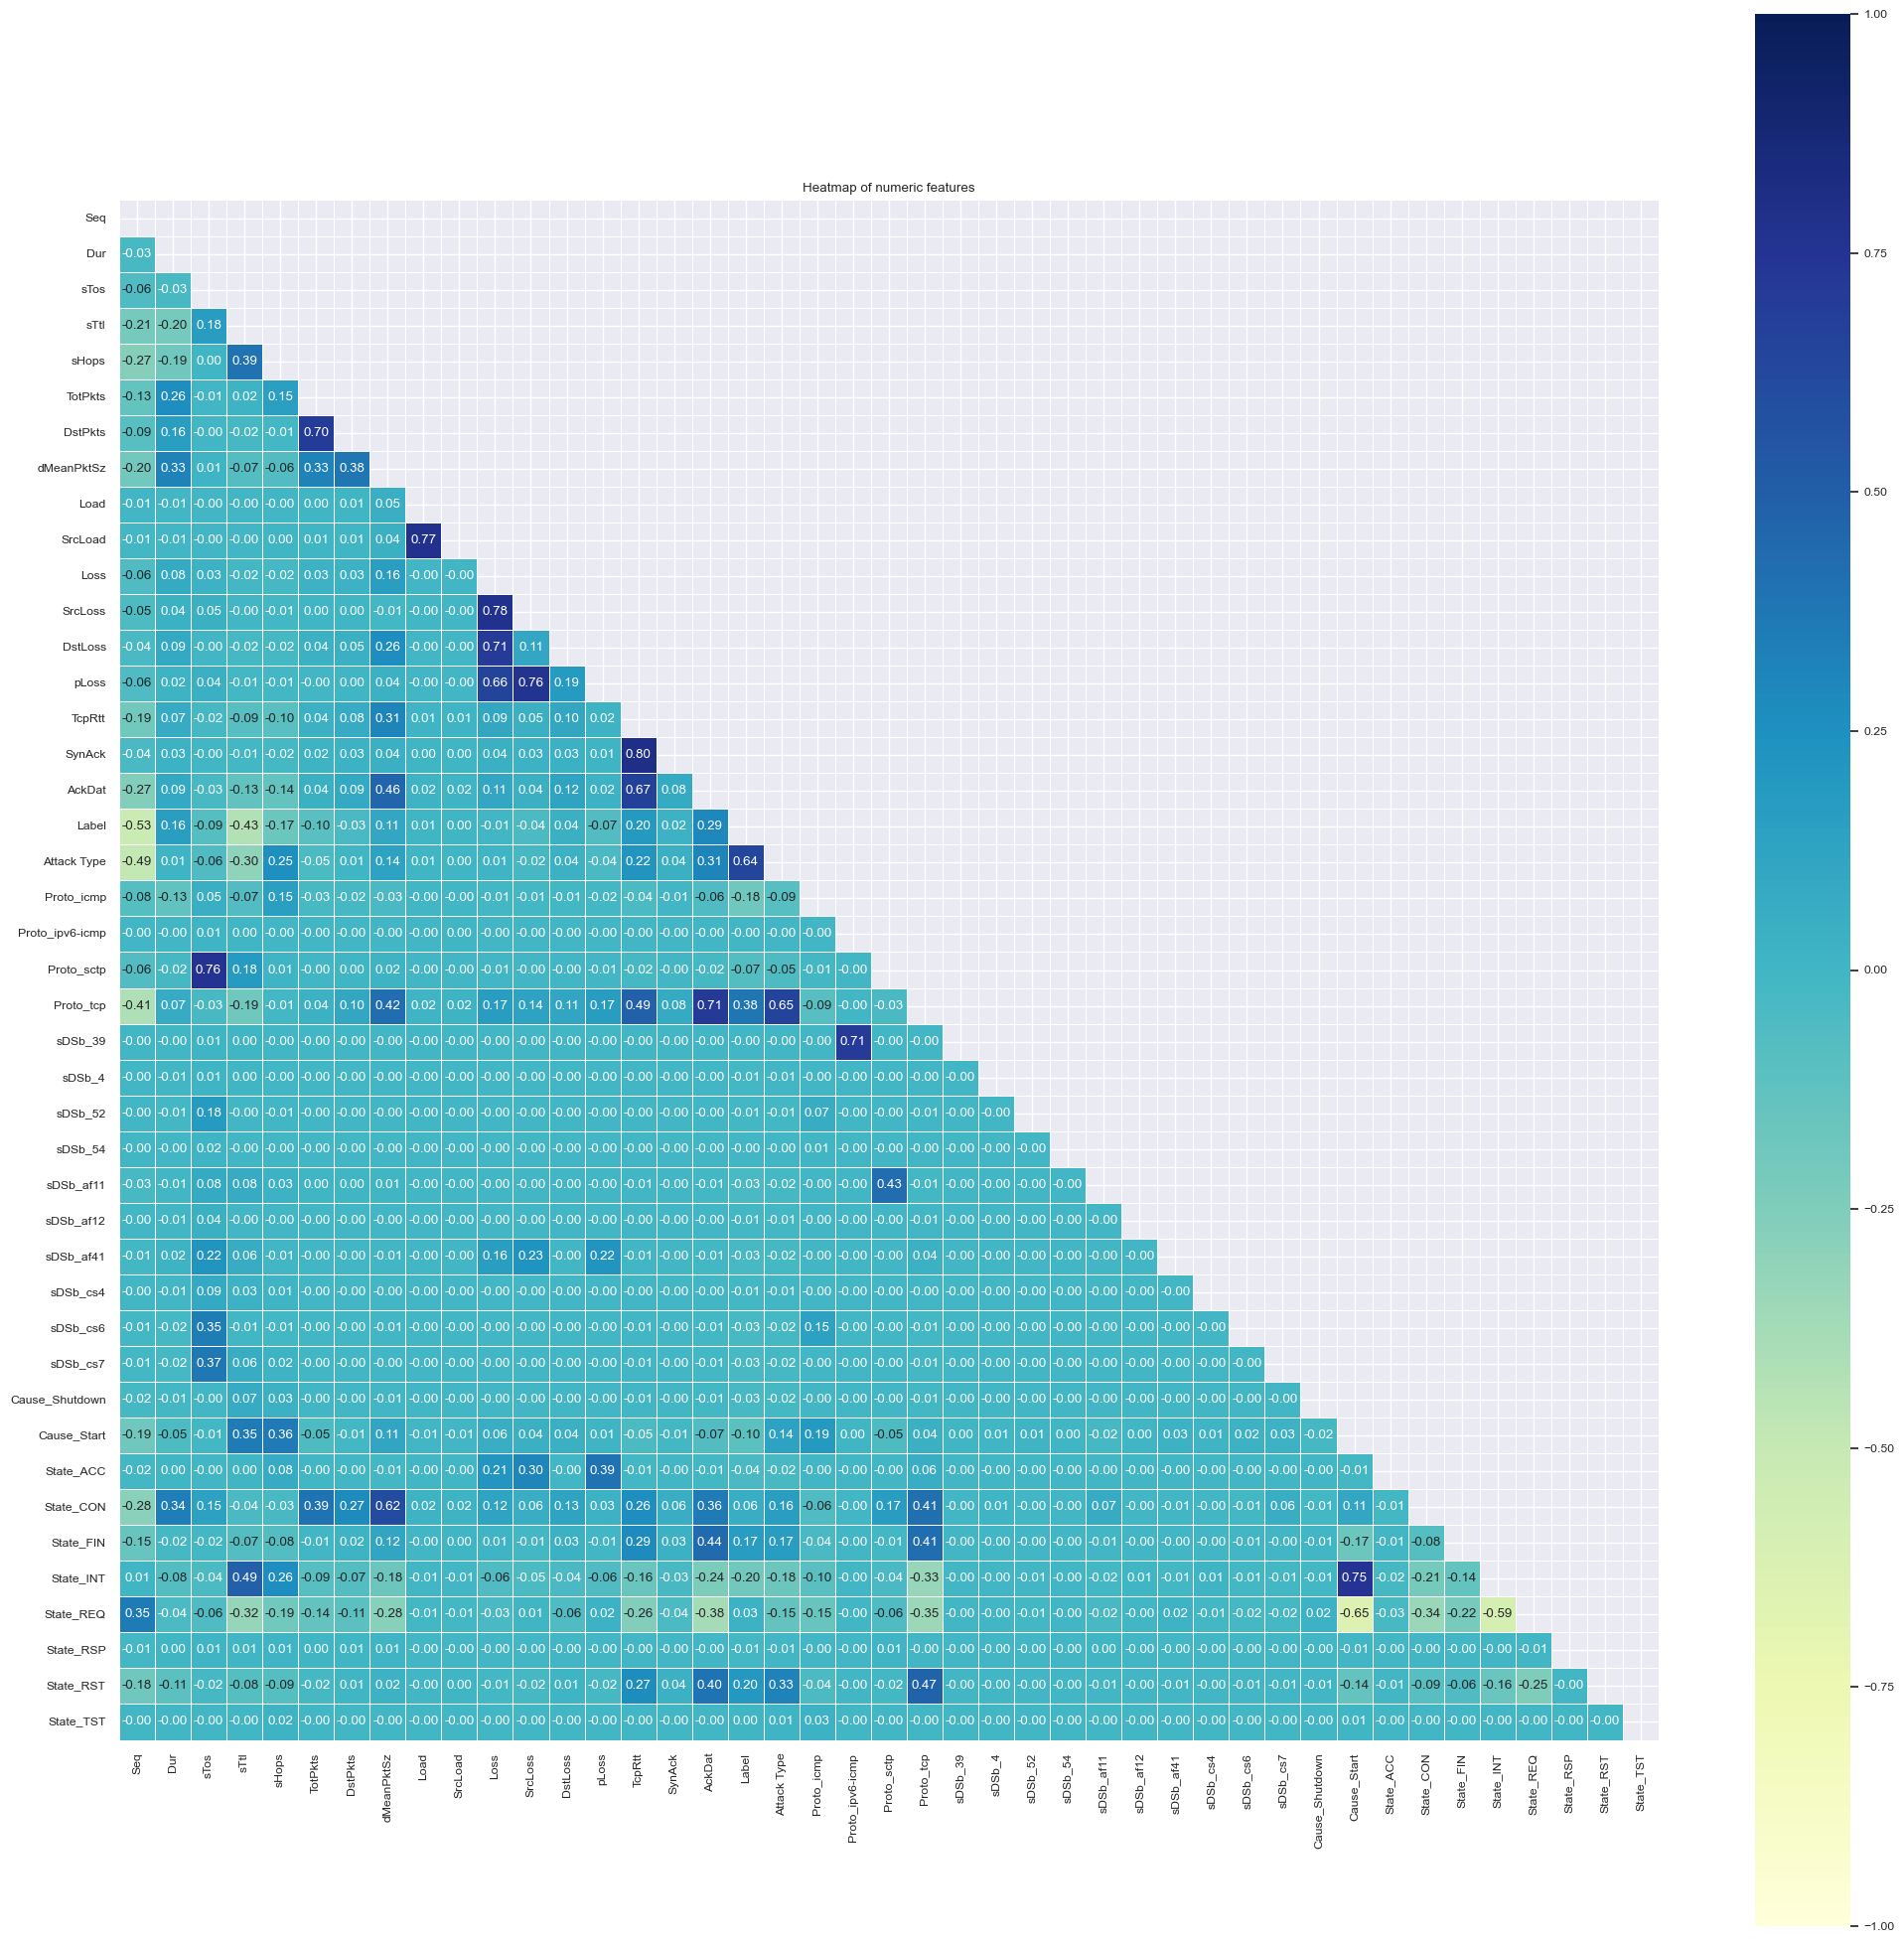

In [44]:
plt.figure(figsize = (25,25))
plt.rcParams.update({'font.size': 8})
numeric_corr = clean_df.corr(numeric_only=True)
sns.set(style="darkgrid",font_scale=0.8)
mask = np.triu(np.ones_like(numeric_corr, dtype=bool))
sns.heatmap(numeric_corr, cmap="YlGnBu", vmin = -1, vmax = 1, center = 0, annot=True, fmt=".2f", square=True, linewidths=.5, mask = mask)
plt.title("Heatmap of numeric features")
plt.savefig('images/heatmap_identify_relevent_features_encoded_cleaned.png', bbox_inches='tight')
plt.show()
plt.close()
plt.clf()

In [45]:
sns.reset_orig() 
plt.close()
plt.clf()

In [46]:
data = clean_df
clean_df.shape

(1215655, 43)

### Train/Test Split - One for Binary classification and the other for Multi-class classification

With your data prepared, split it into a train and test set.

In [47]:
test_size = 0.3
random_state = 42

In [48]:
# Train/Test split for binary classification - 'Label' - Melicious attack detection
Xbin = data.drop(['Attack Type', 'Label'], axis=1) 
ybin = data['Label']
Xbin_train_tmp, Xbin_test_tmp, ybin_train, ybin_test = train_test_split(Xbin, ybin, test_size=test_size, random_state=random_state)

scaler_train = StandardScaler()
Xbin_train = pd.DataFrame(scaler_train.fit_transform(Xbin_train_tmp), columns=Xbin_train_tmp.columns)
scaler_test = StandardScaler()
Xbin_test = pd.DataFrame(scaler_test.fit_transform(Xbin_test_tmp), columns=Xbin_test_tmp.columns)

print( "Xbin_train shape = " + str(Xbin_train.shape) + "\n Xbin_test shape = " + str(Xbin_test.shape))
print( "ybin_train shape = " + str(ybin_train.shape) + "\n ybin_test shape = " + str(ybin_test.shape))
Xbin_train.head()

Xbin_train shape = (850958, 41)
 Xbin_test shape = (364697, 41)
ybin_train shape = (850958,)
 ybin_test shape = (364697,)


Seq       Dur      sTos      sTtl     sHops   TotPkts   DstPkts  \
0  2.070873 -0.807021 -0.069237 -0.329345 -0.352366 -0.165054 -0.111893   
1 -0.619749  0.715383 -0.069237 -0.329345 -0.352366 -0.125414 -0.111893   
2 -0.781195 -0.807021 -0.069237 -0.329345 -0.352366 -0.165054 -0.034843   
3 -0.967806  0.720621 -0.069237 -0.329345 -0.352366 -0.125414 -0.111893   
4  0.583671  0.715967 -0.069237 -0.329345 -0.352366 -0.125414 -0.111893   

   dMeanPktSz      Load   SrcLoad      Loss   SrcLoss  DstLoss    pLoss  \
0   -0.287842 -0.008214 -0.010969 -0.091038 -0.074202 -0.06135 -0.09457   
1   -0.287842 -0.008214 -0.010957 -0.091038 -0.074202 -0.06135 -0.09457   
2    0.018933 -0.008214 -0.010969 -0.091038 -0.074202 -0.06135 -0.09457   
3   -0.287842 -0.008214 -0.010958 -0.091038 -0.074202 -0.06135 -0.09457   
4   -0.287842 -0.008214 -0.010957 -0.091038 -0.074202 -0.06135 -0.09457   

     TcpRtt    SynAck    AckDat  Proto_icmp  Proto_ipv6-icmp  Proto_sctp  \
0 -0.265714 -0.044344 -0.388247    -0.15843        -0.001533   -0.060035   
1 -0.265714 -0.044344 -0.388247    -0.15843        -0.001533   -0.060035   
2  5.078216  0.081540  8.386164    -0.15843        -0.001533   -0.060035   
3 -0.265714 -0.044344 -0.388247    -0.15843        -0.001533   -0.060035   
4 -0.265714 -0.044344 -0.388247    -0.15843        -0.001533   -0.060035   

   Proto_tcp   sDSb_39    sDSb_4   sDSb_52   sDSb_54  sDSb_af11  sDSb_af12  \
0  -0.544995 -0.001084 -0.007817 -0.010342 -0.001084  -0.025616  -0.010455   
1  -0.544995 -0.001084 -0.007817 -0.010342 -0.001084  -0.025616  -0.010455   
2   1.834878 -0.001084 -0.007817 -0.010342 -0.001084  -0.025616  -0.010455   
3  -0.544995 -0.001084 -0.007817 -0.010342 -0.001084  -0.025616  -0.010455   
4  -0.544995 -0.001084 -0.007817 -0.010342 -0.001084  -0.025616  -0.010455   

   sDSb_af41  sDSb_cs4  sDSb_cs6  sDSb_cs7  Cause_Shutdown  Cause_Start  \
0    -0.0204 -0.009199 -0.023307 -0.020687       -0.024247    -0.816894   
1    -0.0204 -0.009199 -0.023307 -0.020687       -0.024247    -0.816894   
2    -0.0204 -0.009199 -0.023307 -0.020687       -0.024247    -0.816894   
3    -0.0204 -0.009199 -0.023307 -0.020687       -0.024247    -0.816894   
4    -0.0204 -0.009199 -0.023307 -0.020687       -0.024247     1.224149   

   State_ACC  State_CON  State_FIN  State_INT  State_REQ  State_RSP  \
0  -0.030114  -0.349244  -0.226162  -0.608926   1.031632  -0.007511   
1  -0.030114  -0.349244  -0.226162  -0.608926   1.031632  -0.007511   
2  -0.030114  -0.349244  -0.226162  -0.608926  -0.969338  -0.007511   
3  -0.030114  -0.349244  -0.226162  -0.608926   1.031632  -0.007511   
4  -0.030114  -0.349244  -0.226162   1.642236  -0.969338  -0.007511   

   State_RST  State_TST  
0  -0.257647  -0.004336  
1  -0.257647  -0.004336  
2   3.881275  -0.004336  
3  -0.257647  -0.004336  
4  -0.257647  -0.004336

In [49]:
# Train/Test split for multi-class classification - 'Attack Type' - Determine type of melicious attack
Xmc = data.drop(['Attack Type', 'Label'], axis=1) 
ymc = data['Attack Type']
Xmc_train_tmp, Xmc_test_tmp, ymc_train, ymc_test = train_test_split(Xmc, ymc, test_size=test_size, random_state=random_state)

scaler_train = StandardScaler()
Xmc_train = pd.DataFrame(scaler_train.fit_transform(Xmc_train_tmp), columns=Xmc_train_tmp.columns)
scaler_test = StandardScaler()
Xmc_test = pd.DataFrame(scaler_test.fit_transform(Xmc_test_tmp), columns=Xmc_test_tmp.columns)

print( "Xmc_train shape = " + str(Xmc_train.shape) + "\n Xmc_test shape = " + str(Xmc_test.shape))
print( "ymc_train shape = " + str(ymc_train.shape) + "\n ymc_test shape = " + str(ymc_test.shape))
Xmc_train.head()

Xmc_train shape = (850958, 41)
 Xmc_test shape = (364697, 41)
ymc_train shape = (850958,)
 ymc_test shape = (364697,)


Seq       Dur      sTos      sTtl     sHops   TotPkts   DstPkts  \
0  2.070873 -0.807021 -0.069237 -0.329345 -0.352366 -0.165054 -0.111893   
1 -0.619749  0.715383 -0.069237 -0.329345 -0.352366 -0.125414 -0.111893   
2 -0.781195 -0.807021 -0.069237 -0.329345 -0.352366 -0.165054 -0.034843   
3 -0.967806  0.720621 -0.069237 -0.329345 -0.352366 -0.125414 -0.111893   
4  0.583671  0.715967 -0.069237 -0.329345 -0.352366 -0.125414 -0.111893   

   dMeanPktSz      Load   SrcLoad      Loss   SrcLoss  DstLoss    pLoss  \
0   -0.287842 -0.008214 -0.010969 -0.091038 -0.074202 -0.06135 -0.09457   
1   -0.287842 -0.008214 -0.010957 -0.091038 -0.074202 -0.06135 -0.09457   
2    0.018933 -0.008214 -0.010969 -0.091038 -0.074202 -0.06135 -0.09457   
3   -0.287842 -0.008214 -0.010958 -0.091038 -0.074202 -0.06135 -0.09457   
4   -0.287842 -0.008214 -0.010957 -0.091038 -0.074202 -0.06135 -0.09457   

     TcpRtt    SynAck    AckDat  Proto_icmp  Proto_ipv6-icmp  Proto_sctp  \
0 -0.265714 -0.044344 -0.388247    -0.15843        -0.001533   -0.060035   
1 -0.265714 -0.044344 -0.388247    -0.15843        -0.001533   -0.060035   
2  5.078216  0.081540  8.386164    -0.15843        -0.001533   -0.060035   
3 -0.265714 -0.044344 -0.388247    -0.15843        -0.001533   -0.060035   
4 -0.265714 -0.044344 -0.388247    -0.15843        -0.001533   -0.060035   

   Proto_tcp   sDSb_39    sDSb_4   sDSb_52   sDSb_54  sDSb_af11  sDSb_af12  \
0  -0.544995 -0.001084 -0.007817 -0.010342 -0.001084  -0.025616  -0.010455   
1  -0.544995 -0.001084 -0.007817 -0.010342 -0.001084  -0.025616  -0.010455   
2   1.834878 -0.001084 -0.007817 -0.010342 -0.001084  -0.025616  -0.010455   
3  -0.544995 -0.001084 -0.007817 -0.010342 -0.001084  -0.025616  -0.010455   
4  -0.544995 -0.001084 -0.007817 -0.010342 -0.001084  -0.025616  -0.010455   

   sDSb_af41  sDSb_cs4  sDSb_cs6  sDSb_cs7  Cause_Shutdown  Cause_Start  \
0    -0.0204 -0.009199 -0.023307 -0.020687       -0.024247    -0.816894   
1    -0.0204 -0.009199 -0.023307 -0.020687       -0.024247    -0.816894   
2    -0.0204 -0.009199 -0.023307 -0.020687       -0.024247    -0.816894   
3    -0.0204 -0.009199 -0.023307 -0.020687       -0.024247    -0.816894   
4    -0.0204 -0.009199 -0.023307 -0.020687       -0.024247     1.224149   

   State_ACC  State_CON  State_FIN  State_INT  State_REQ  State_RSP  \
0  -0.030114  -0.349244  -0.226162  -0.608926   1.031632  -0.007511   
1  -0.030114  -0.349244  -0.226162  -0.608926   1.031632  -0.007511   
2  -0.030114  -0.349244  -0.226162  -0.608926  -0.969338  -0.007511   
3  -0.030114  -0.349244  -0.226162  -0.608926   1.031632  -0.007511   
4  -0.030114  -0.349244  -0.226162   1.642236  -0.969338  -0.007511   

   State_RST  State_TST  
0  -0.257647  -0.004336  
1  -0.257647  -0.004336  
2   3.881275  -0.004336  
3  -0.257647  -0.004336  
4  -0.257647  -0.004336

### Cross-validation
    Algorithms to consider:

    - Logistic Regression
    - KNeighborsClassifier
    - DecisionTreeClassifier
    - SVM
    
    

In [50]:
def lists_to_dict (keys, items):
    return {key: item for key,item in zip(keys, items)}

# models names
model_names = ['LR', 'KNN', 'DT']
# param grids for gridsearch
param_grids = [
    {
        'penalty' : ['l1', 'l2', 'none'],
        'C' : np.logspace(-4, 4, 20),
        'solver' : ['lbfgs','newton-cg','sag','saga'],
        'max_iter' : [100, 1000,2500, 5000],
        'multi_class' : ['multinomial']
    },
    { 
        'n_neighbors' : [5,7,9,11,13,15],
        'weights' : ['uniform','distance'],
        'metric' : ['minkowski','euclidean','manhattan']
    },
    {
        'max_depth': [2, 3, 5, 10, 20],
        'min_samples_leaf': [5, 10, 20, 50, 100],
        'criterion': ["gini", "entropy"]
    },
    {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf', 'linear']
    }  
]

param_grids = lists_to_dict(model_names, param_grids)

# models for gridsearch
models = [
    LogisticRegression(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    SVC(probability=True)
]
models = lists_to_dict(model_names, models)

In [51]:
from joblib import dump, load
import copy
import pickle

def n_best (gs_res, n=1):
    ind = np.where(gs_res['rank_test_score'] == n)[0][0]
    mu = gs_res["mean_test_score"][ind]
    std = gs_res["std_test_score"][ind]
    params = gs_res["params"][ind]
    return params, mu, std
   
def grid_search(models, params, X, Y, random_seed=None, silent=False, **kwargs):
    # result dict
    result = []
    rmodels = []
   
    for key in models.keys():
        print(key)
        res = {}
        res['algorithm'] = key
        # set seed
        if random_seed is not None:
            np.random.seed(random_seed)
        x = X
        # gridsearch
        gs = GridSearchCV(estimator=models[key], param_grid=params[key], cv=3, scoring = "accuracy", n_jobs=-1, verbose=1).fit(x, Y)
            
        # best estimator parameters, cross validation mean score and score std
        res['params'], res['mean_score'], res['std_score'] = n_best(gs.cv_results_)
        # save cv_results_
        res['cv_result'] = copy.deepcopy(gs.cv_results_)
        result.append(res)
        print(res)
        rmodels.append(gs.best_estimator_)
    return result, rmodels


In [52]:
# Evalute the ROC
def plot_confusion_matrix_func(class_type, models, X_t, y_t, x, y, x_dim, y_dim):
    sns.reset_orig() 
    fig, ax = plt.subplots(x,y, figsize=(x_dim, y_dim))
    i = 0
    j = 0
    for model in models:
        # Confusion Matrix
        cm = confusion_matrix(y_t, model.predict(X_t))
        disp_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
        if x > 1:
            disp_cm.plot(ax=ax[i,j])
        else:
            disp_cm.plot(ax=ax[j])

        try:
            fpr, tpr, thresholds = roc_curve(y_t, model.predict_proba(X_t)[:, 1], pos_label=1)
            fp = cm[0][1]
            fn = cm[1][0]
            auc = round(skl_auc(fpr, tpr), 2)
            print("\nModel = " + str(model) + " AUC = " + str(auc))
            #plt.savefig('images/test_dt_confusion_matrix.png')
            if x > 1:
                ax[i,j].set(
                    #xlabel="False Positive Rate",
                    #ylabel="True Positive Rate",
                    title= "Confusion Matrix - " + str(type(model).__name__),
                )
            else:
                ax[j].set(
                    #xlabel="False Positive Rate",
                    #ylabel="True Positive Rate",
                    title= "Confusion Matrix - " + str(type(model).__name__),
                )
        except:
            print("Method does not exit ...")
            
            
        if j == (y-1):
            j = 0
            i = i+1
        else:
            j = j + 1          
            
    plt.savefig('images/confusion_matrix_' + str(class_type) + '.png', bbox_inches='tight')
    plt.show()
    plt.close()
    plt.clf()

### Detecting melicious attack - binary classification model performance

In [53]:
bin_res_dict, rmodels = grid_search(models, param_grids, Xbin_train, ybin_train, random_seed=42)


LR
Fitting 3 folds for each of 960 candidates, totalling 2880 fits


/Users/haswarey/Projects/AIML/AIML/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/haswarey/Projects/AIML/AIML/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/haswarey/Projects/AIML/AIML/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/haswarey/Projects/AIML/AIML/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/haswarey/Projects/AIML/AIML/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

{'algorithm': 'LR', 'params': {'C': 4.281332398719396, 'max_iter': 2500, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag'}, 'mean_score': 0.9901463994562015, 'std_score': 0.0001500307059041101, 'cv_result': {'mean_fit_time': array([1.46701423e+00, 1.58085569e+00, 1.85020963e+00, 1.00689973e+02,
       5.59950034e+00, 9.63632997e+00, 7.35835560e+01, 9.40580506e+01,
       2.40134176e+00, 2.39124497e+00, 2.37446364e+00, 2.36893439e+00,
       1.08749898e+00, 8.80568266e-01, 7.06101815e-01, 1.22594442e+02,
       3.81667733e+00, 7.74017779e+00, 7.18100766e+01, 1.23415395e+02,
       4.29181735e-01, 4.40383673e-01, 3.88766686e-01, 3.74760946e-01,
       3.98870389e-01, 3.97595882e-01, 3.72085253e-01, 1.22325003e+02,
       3.43577703e+00, 7.21794216e+00, 7.10722520e+01, 1.22739424e+02,
       3.99841944e-01, 4.69441970e-01, 4.46330945e-01, 3.28000069e-01,
       3.27355067e-01, 5.01711289e-01, 3.34419568e-01, 1.21662083e+02,
       3.26950232e+00, 7.20859400e+00, 7.08965896e+

In [54]:
bin_results = pd.DataFrame(bin_res_dict)
bin_results

algorithm                                             params  mean_score  \
0        LR  {'C': 4.281332398719396, 'max_iter': 2500, 'mu...    0.990146   
1       KNN  {'metric': 'manhattan', 'n_neighbors': 5, 'wei...    0.999521   
2        DT  {'criterion': 'entropy', 'max_depth': 10, 'min...    0.999706   

   std_score                                          cv_result  
0   0.000150  {'mean_fit_time': [1.467014233271281, 1.580855...  
1   0.000026  {'mean_fit_time': [1.7499810059865315, 2.31384...  
2   0.000014  {'mean_fit_time': [1.6299346288045247, 1.79270...

In [55]:
lr = rmodels[0]
lr_train_acc = lr.score(Xbin_train, ybin_train)
lr_test_acc = lr.score(Xbin_test, ybin_test)
print('The accuracy of the Logistic Regression model for training data is {:.2f}'.format(lr_train_acc))
print('The accuracy of the Logistic Regression model for test data is {:.2f}'.format(lr_test_acc))

The accuracy of the Logistic Regression model for training data is 0.99
The accuracy of the Logistic Regression model for test data is 0.99


In [56]:
knn = rmodels[1] 
knn_train_acc = knn.score(Xbin_train, ybin_train)
knn_test_acc = knn.score(Xbin_test, ybin_test)
print('The accuracy of the KNeighborsClassifier model for training data is  {:.2f}'.format(knn_train_acc))
print('The accuracy of the KNeighborsClassifier model for test data is {:.2f}'.format(knn_test_acc))

The accuracy of the KNeighborsClassifier model for training data is  1.00
The accuracy of the KNeighborsClassifier model for test data is 1.00


In [57]:
dt = rmodels[2]
dt_train_acc = dt.score(Xbin_train, ybin_train)
dt_test_acc = dt.score(Xbin_test, ybin_test)
print('The accuracy of the DecisionTreeClassifier model for training data is  {:.2f}'.format(dt_train_acc))
print('The accuracy of the DecisionTreeClassifier model for test data is {:.2f}'.format(dt_test_acc))

The accuracy of the DecisionTreeClassifier model for training data is  1.00
The accuracy of the DecisionTreeClassifier model for test data is 1.00


svc = rmodels[3]
svc_train_acc = svc.score(Xbin_train, ybin_train)
svc_test_acc = svc.score(Xbin_test, ybin_test)
print('The accuracy of the SVC model for training data is  {:.2f}'.format(svc_train_acc))
print('The accuracy of the SVC model for test data is {:.2f}'.format(svc_test_acc))

In [58]:
model_comparison_df = pd.DataFrame({ 'Model': ['Logistic Regression', 'KNN', 'Decision Tree'], \
                          'Train Accuracy':[lr_train_acc, knn_train_acc, dt_train_acc], \
                          'Test Accuracy':[lr_test_acc, knn_test_acc, dt_test_acc]})

print(model_comparison_df)

                 Model  Train Accuracy  Test Accuracy
0  Logistic Regression        0.990149       0.990104
1                  KNN        0.999700       0.999548
2        Decision Tree        0.999766       0.999619



Model = LogisticRegression(C=4.281332398719396, max_iter=2500,
                   multi_class='multinomial', solver='sag') AUC = 0.99

Model = KNeighborsClassifier(metric='manhattan') AUC = 1.0

Model = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5) AUC = 1.0


<Figure size 640x480 with 0 Axes>

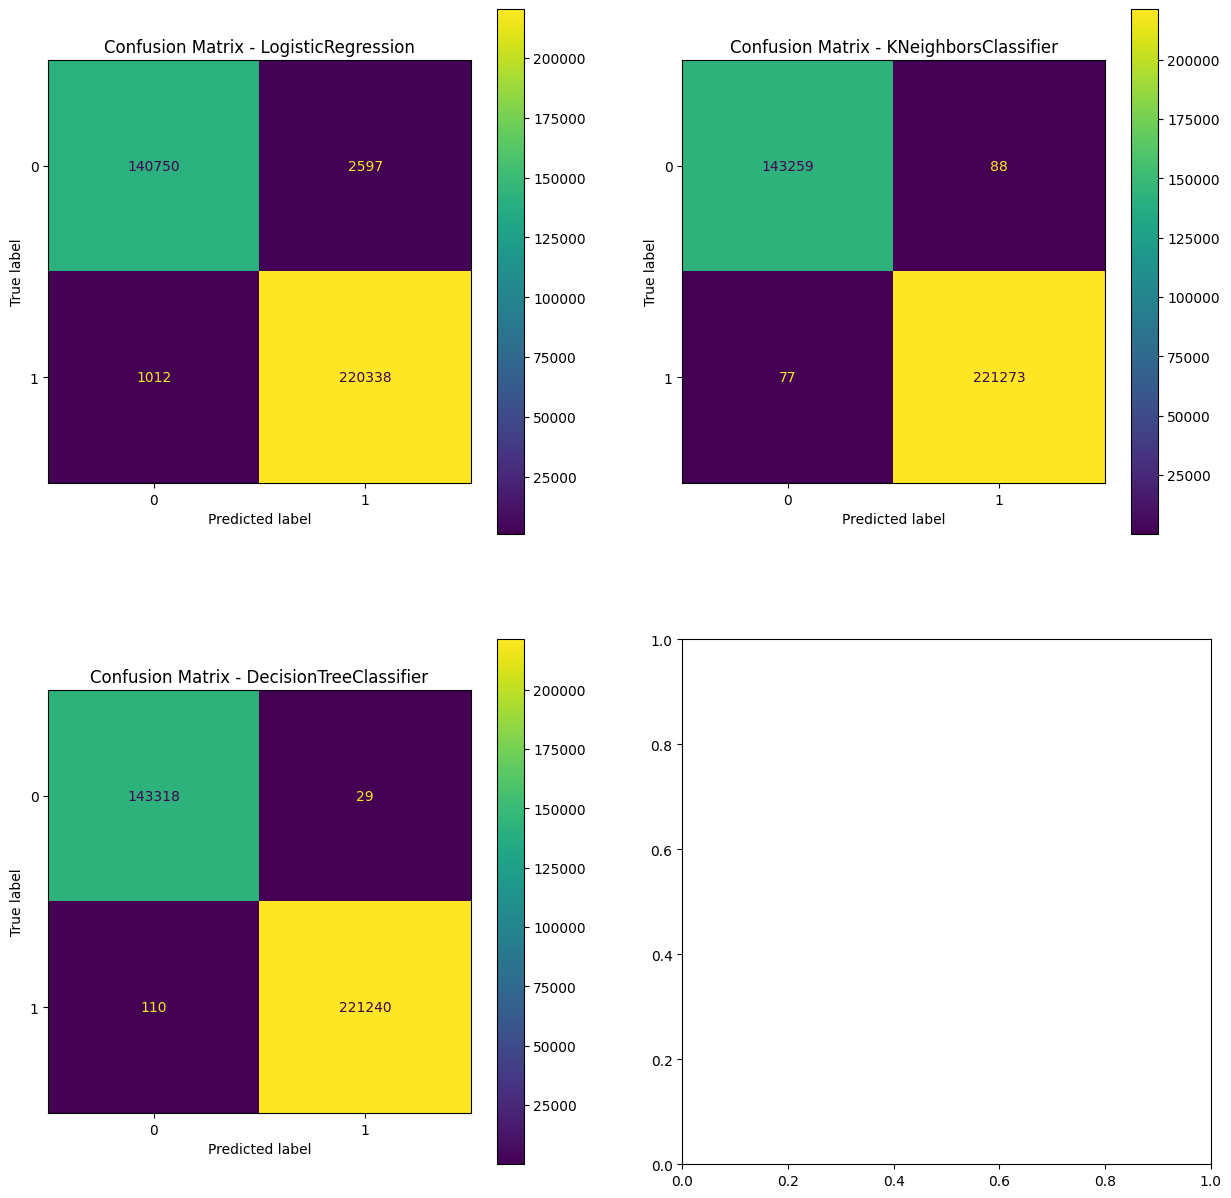

In [59]:
cmodels = [lr,knn, dt]
plot_confusion_matrix_func('binary', cmodels, Xbin_test, ybin_test, 2, 2, 15, 15)

In [60]:
best_model_bin = dt

### Best model for binary classification confusion matrix with ROC plot

<Figure size 640x480 with 0 Axes>

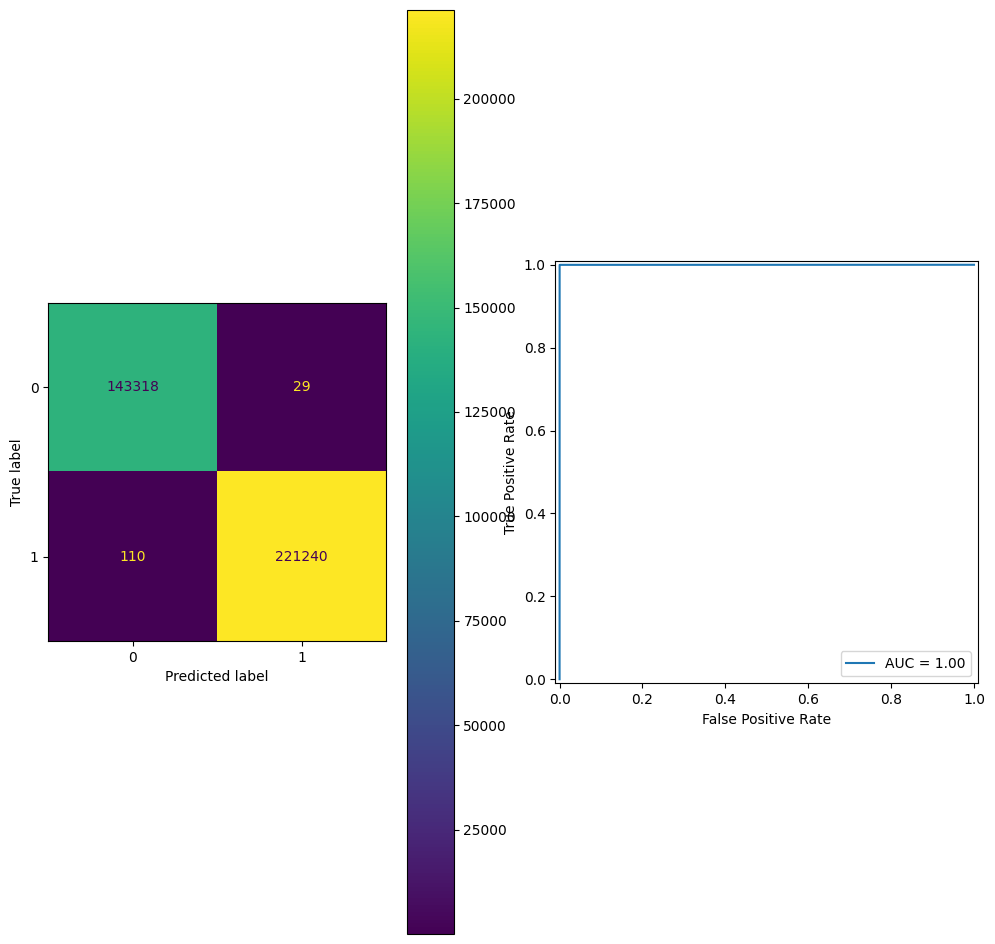

In [61]:
sns.reset_orig() 
fig, ax = plt.subplots(1, 2, figsize=(12, 12))

# Confusion Matrix
cm = confusion_matrix(ybin_test, best_model_bin.predict(Xbin_test), labels = best_model_bin.classes_)
disp_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_model_bin.classes_)
disp_cm.plot(ax=ax[0])

fpr, tpr, thresholds = roc_curve(ybin_test, best_model_bin.predict_proba(Xbin_test)[:, 1], pos_label=1)
disp_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=skl_auc(fpr, tpr))
disp_roc.plot(ax=ax[1])

fp = cm[0][1]
fn = cm[1][0]
auc = round(skl_auc(fpr, tpr), 2)

plt.savefig('images/test_best_model_binary_confusion_matrix.png', bbox_inches='tight')
plt.show()

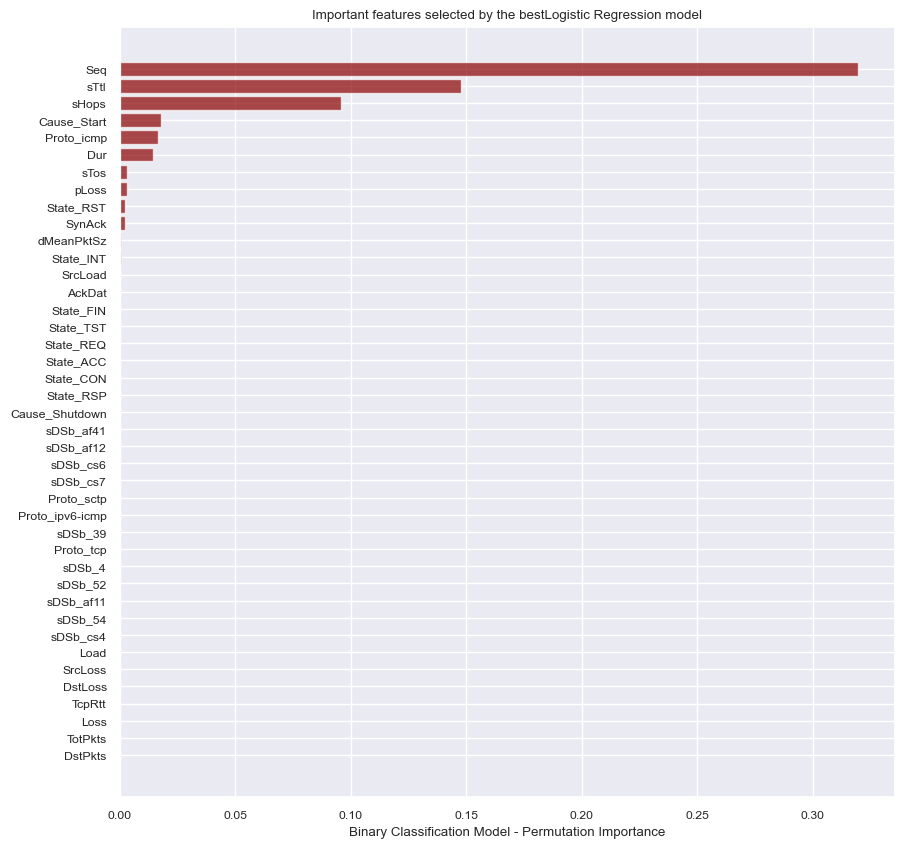

In [62]:
# Using binary best model, lets use it to get the top features that were selected. 
# Best on the result, features will be selected for further analysis before they are dropped.

results = permutation_importance(best_model_bin, Xbin_train, ybin_train, n_repeats=30, random_state=42)
important_features = results.importances_mean
sorted_idx = np.argsort(important_features)

sns.set(style="darkgrid",font_scale=0.8)
fig, axs = plt.subplots(figsize=(10, 10))
plt.barh(range(len(sorted_idx)), important_features[sorted_idx], color='darkred', alpha=0.7)
plt.yticks(range(len(sorted_idx)), Xbin_test.columns[sorted_idx]);
plt.xlabel('Binary Classification Model - Permutation Importance')
plt.title('Important features selected by the bestLogistic Regression model')
plt.savefig('images/bin_permutation_importance.png', bbox_inches='tight')
plt.show()
plt.close()
plt.clf()

### Determine melicious attack type - multi-class classification model performance

In [ ]:
mc_res_dict, rmodels = grid_search(models, param_grids, Xmc_train, ymc_train, random_seed=42)


LR
Fitting 3 folds for each of 960 candidates, totalling 2880 fits


/Users/haswarey/Projects/AIML/AIML/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/haswarey/Projects/AIML/AIML/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/haswarey/Projects/AIML/AIML/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/haswarey/Projects/AIML/AIML/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/haswarey/Projects/AIML/AIML/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

In [ ]:
mc_results = pd.DataFrame(mc_res_dict)

In [ ]:
mc_results

In [ ]:
lrmc = rmodels[0]
lr_train_acc = lrmc.score(Xmc_train, ymc_train)
lr_test_acc = lrmc.score(Xmc_test, ymc_test)
print('The accuracy of the Logistic Regression model for training data is {:.2f}'.format(lr_train_acc))
print('The accuracy of the Logistic Regression model for test data is {:.2f}'.format(lr_test_acc))

In [ ]:
knnmc = rmodels[1] 
knn_train_acc = knnmc.score(Xmc_train, ymc_train)
knn_test_acc = knnmc.score(Xmc_test, ymc_test)
print('The accuracy of the KNeighborsClassifier model for training data is  {:.2f}'.format(knn_train_acc))
print('The accuracy of the KNeighborsClassifier model for test data is {:.2f}'.format(knn_test_acc))

In [ ]:
dtmc = rmodels[2]
dt_train_acc = dtmc.score(Xmc_train, ymc_train)
dt_test_acc = dtmc.score(Xmc_test, ymc_test)
print('The accuracy of the DecisionTreeClassifier model for training data is  {:.2f}'.format(dt_train_acc))
print('The accuracy of the DecisionTreeClassifier model for test data is {:.2f}'.format(dt_test_acc))

svcmc = rmodels[3]
svc_train_acc = svcmc.score(Xmc_train, ymc_train)
svc_test_acc = svcmc.score(Xmc_test, ymc_test)
print('The accuracy of the SVC model for training data is  {:.2f}'.format(svc_train_acc))
print('The accuracy of the SVC model for test data is {:.2f}'.format(svc_test_acc))

In [ ]:
model_comparison_df = pd.DataFrame({ 'Model': ['Logistic Regression', 'KNN', 'Decision Tree'], \
                          'Train Accuracy':[lr_train_acc, knn_train_acc, dt_train_acc], \
                          'Test Accuracy':[lr_test_acc, knn_test_acc, dt_test_acc]})

print(model_comparison_df)

In [ ]:
cmodels = [lrmc,knnmc, dtmc]
plot_confusion_matrix_func('multi-class', cmodels, Xmc_test, ymc_test, 2, 2, 15, 15)

In [ ]:
best_model_mc = dtmc

### Best model for multi-class classification confusion matrix with ROC plot

In [ ]:
sns.reset_orig() 
fig, ax = plt.subplots(1, 2, figsize=(12, 12))

# Confusion Matrix
cm = confusion_matrix(ymc_test, best_model_mc.predict(Xmc_test), labels = best_model_mc.classes_)
disp_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_model_mc.classes_)
disp_cm.plot(ax=ax[0])

fpr, tpr, thresholds = roc_curve(ymc_test, best_model_mc.predict_proba(Xmc_test)[:, 1], pos_label=1)
disp_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=skl_auc(fpr, tpr))
disp_roc.plot(ax=ax[1])

fp = cm[0][1]
fn = cm[1][0]
auc = round(skl_auc(fpr, tpr), 2)

plt.savefig('images/test_best_model_multi-class_confusion_matrix.png', bbox_inches='tight')
plt.show()

### Training

In [ ]:
models

In [ ]:
def train_all(res_tab, Xtrain, Ytrain, model_list=None):
    if model_list is None:
        model_list = res_tab['algorithm'].unique()
    table = res_tab[res_tab['algorithm'].isin(model_list)].set_index('algorithm')
    result = {}
    for model_name in model_list:
        model = copy.deepcopy(models[model_name])
        model.set_params(**table.loc[model_name, 'params'])
        model.fit(Xtrain, Ytrain)
        result[model_name] = model
    return result 

In [ ]:
bin_models = train_all(bin_results, Xbin_train, ybin_train)

In [ ]:
mc_models = train_all(mc_results, Xmc_train, ymc_train)

### Evaluating models

In [ ]:
def eval_all(models, Xtest, Ytest, model_list=None, **kwargs):
    if model_list is None:
        model_list = list(models.keys())
    for key, model in models.items():
        print(key)
        y_pred = model.predict(Xtest)
        print(classification_report(Ytest, y_pred, **kwargs))

### Binary

In [ ]:
eval_all(bin_models, Xbin_test, ybin_test, target_names={'Benign', 'Malicious'})

### Multi-class

In [ ]:
eval_all(mc_models, Xmc_test, ymc_test, target_names={'Benign', 'UDPFlood', 'HTTPFlood', 'SlowrateDoS', \
                                                      'TCPConnectScan', 'SYNScan', 'UDPScan', 'SYNFlood', 'ICMPFlood'})

In [ ]:
# Different Score View - Multi-class
labels = np.array(['Benign', 'UDPFlood', 'HTTPFlood', 'SlowrateDoS', 'TCPConnectScan', 'SYNScan', 'UDPScan', 'SYNFlood', 'ICMPFlood'])
model_list_mc = [lrmc, knnmc, dtmc]
model_comparison_mc = []
model_name_list_mc = []
for model_mc in model_list_mc:
    ymc_pred = model_mc.predict(Xmc_test)
    precision, recall, fscore, support = score(ymc_test, ymc_pred)
    model_name_list_mc.append(type(model_mc).__name__)
    model_comparison_mc.append(pd.DataFrame({ 'Classes': labels, \
                          'precision':precision, \
                          'recall':recall, \
                          'f1-score':fscore, \
                          'support':support}))

for item, mod_name in zip(model_comparison_mc, model_name_list_mc):
    print("\n\n")
    display("Model: " + mod_name)
    display(item)

In [ ]:
from itertools import combinations
from sklearn.preprocessing import LabelBinarizer

def plot_one_on_one_auc(model, X_te, y_te):
    sns.reset_orig() 
    plt.close()
    label_binarizer = LabelBinarizer().fit(y_te)
    pair_list = list(combinations(np.unique(ymc), 2))
    pair_scores = []
    target_names = np.array(['Benign', 'UDPFlood', 'HTTPFlood', 'SlowrateDoS', 'TCPConnectScan', 'SYNScan', 'UDPScan', 'SYNFlood', 'ICMPFlood'])
    mean_tpr = dict
    #y_score = lr.fit(X_tr, y_tr).predict_proba(X_te)
    fpr, tpr, thresholds = roc_curve(y_te, model.predict_proba(X_te)[:, 1], pos_label=1)
    y_score = model.predict_proba(X_te)
    fig, ax = plt.subplots(9, 4, figsize=(25, 80))
    plt.figure().clear()
    i = 0
    j = 0
    for ix, (label_a, label_b) in enumerate(pair_list):
        a_mask = y_te == label_a
        b_mask = y_te == label_b
        ab_mask = np.logical_or(a_mask, b_mask)
        
        fpr_grid = fpr
        a_true = a_mask[ab_mask]
        b_true = b_mask[ab_mask]

        idx_a = np.flatnonzero(label_binarizer.classes_ == label_a)[0]
        idx_b = np.flatnonzero(label_binarizer.classes_ == label_b)[0]

        fpr_a, tpr_a, _ = roc_curve(a_true, y_score[ab_mask, idx_a])
        fpr_b, tpr_b, _ = roc_curve(b_true, y_score[ab_mask, idx_b])

        mean_tpr[ix] = np.zeros_like(fpr_grid)
        mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
        mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
        mean_tpr[ix] /= 2
        mean_score = metrics.auc(fpr_grid, mean_tpr[ix])
        pair_scores.append(mean_score)

        #fig, ax = plt.subplots(figsize=(6, 6))
        plt.plot(
            fpr_grid,
            mean_tpr[ix],
            #label=f"Mean {label_a} vs {label_b} (AUC = {mean_score :.2f})",
            linestyle=":",
            linewidth=4,
         
        )
    
        
        RocCurveDisplay.from_predictions(
            a_true,
            y_score[ab_mask, idx_a],
            ax=ax[i,j],
            name=f"{target_names[int(label_a)]} as positive class",
        )

        RocCurveDisplay.from_predictions(
            b_true,
            y_score[ab_mask, idx_b],
            ax=ax[i,j],
            name=f"{target_names[int(label_b)]} as positive class",
            plot_chance_level=True,
        )
        ax[i,j].set(
            xlabel="False Positive Rate",
            ylabel="True Positive Rate",
            title=f"{target_names[idx_a]} vs {target_names[int(label_b)]} ROC curves",
        )
        if j == 3:
            j = 0
            i = i + 1
        else:
            j = j + 1

    print(f"Macro-averaged One-vs-One ROC AUC score:\n{np.average(pair_scores):.2f}")
    plt.savefig('images/test_best_model_multi-class_one_vs_one_matrix.png', bbox_inches='tight')
    plt.show()
    plt.close()
    plt.clf()

In [ ]:

plot_one_on_one_auc(best_model_mc, Xmc_test, ymc_test)

In [ ]:
# Using multi-class best model, lets use it to get the top features that were selected. 
# Best on the result, features will be selected for further analysis before they are dropped.

results = permutation_importance(best_model_mc, Xmc_train, ymc_train, n_repeats=30, random_state=42)
important_features = results.importances_mean
sorted_idx = np.argsort(important_features)

sns.set(style="darkgrid",font_scale=0.8)
fig, axs = plt.subplots(figsize=(10, 10))
plt.barh(range(len(sorted_idx)), important_features[sorted_idx], color='darkred', alpha=0.7)
plt.yticks(range(len(sorted_idx)), Xmc_test.columns[sorted_idx]);
plt.xlabel('Multi-class Classification Model - Permutation Importance')
plt.title('Important features selected by the best model')
plt.savefig('images/multi-class_permutation_importance.png', bbox_inches='tight')
plt.show()
plt.close()
plt.clf()

#### Conclusion
* The data has class disbalance
* From the scores, the data is suited for multi-class classification. 

Further analysis need to be execute to improve the f1-score to address the above identified risks.  